# 1 Data extraction and modeling

## 1.1 Data extraction

The chosen dataset is composed by the meteorogical and irradiation data of Italy in the year 2017. The NSRDB contains the data of almost every country for various years (from 3 to 30), so the desired data must be extracted using the <a href="https://developer.nrel.gov/docs/solar/nsrdb/meteosat-download/"> provided API</a>.<br>
However, the API documentation contains some minor errors, like the list of possible attributes.

In [ ]:
  #miscellaneous imports
  import pandas as pd
  import numpy as np
  import requests
  import json
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In the following cell some parameters for API requests are initialized

In [ ]:
  # Declare all variables as strings. Spaces must be replaced with '+', i.e., change 'John Smith' to 'John+Smith'.
  
  # You must request posses an NSRDB api key 
  api_key = 'jmtz8p0BnST6BX5IaJg3fkhiyPnqFZmghPvPQarX'
  # Set the attributes to extract (e.g., dhi, ghi, etc.), separated by commas.
  attributes = 'air_temperature,clearsky_dhi,clearsky_dni,clearsky_ghi,cloud_type,dew_point,dhi,dni,fill_flag,ghi,ozone,relative_humidity,solar_zenith_angle,surface_albedo,surface_pressure,total_precipitable_water,wind_direction,wind_speed'
  # Choose year of data
  year = '2017' 
  # Set leap year to true or false. True will return leap day data if present, false will not.
  leap_year = 'false'
  # Set time interval in minutes, i.e., '30' is half hour intervals. Valid intervals are 15, 30, 60.
  interval = '60'
  # Specify Coordinated Universal Time (UTC), 'true' will use UTC, 'false' will use the local time zone of the data.
  # NOTE: In order to use the NSRDB data in SAM, you must specify UTC as 'false'. SAM requires the data to be in the
  # local time zone.
  utc = 'false'
  # Your full name, use '+' instead of spaces.
  your_name = ''
  # Your reason for using the NSRDB.
  reason_for_use = 'beta+testing'
  # Your affiliation
  your_affiliation = 'Sapienza'
  # Your email address
  your_email = ''
 
  mailing_list = 'false'


There's a limit on how much data can be extracted from a single request, so i divided Italy in 26 regions and made the same number of smaller requests.<br>
The limit, as described <a href="https://developer.nrel.gov/docs/solar/nsrdb/guide/"> here</a>, is: (site-count) \* (attribute-count) \* (year-count) \* (24\*365) < 175000000.<br>
The entire Italy is over the limit, because it's (roughly): 28504 \* 18 \* 1 \* 8760 = 249.695.040<br>
To know the site count for each geographical shape, the following API request must be done

In [ ]:
#Here the WKT object is initialized; it can be a point, a multipoint or a polygon; this example is a polygon that represents italy
poly= "POLYGON((7.740620123642183 43.59968828053194,7.454975592392183 43.885423564039804,7.740620123642183 44.090939653420435,7.652729498642183 44.21705737354636,7.103413092392183 44.16979481391069,6.795795904892183 44.51550662355288,6.993549811142183 44.765652799530486,6.598041998642183 45.01472043820472,6.905475005597488 45.97930474976466,8.575396880597488 46.34455299251502,10.421100005597488 46.82778009704588,12.222857818097488 47.03783781479106,13.673053130597488 46.465763644577095,13.804889068097488 45.76512329666311,12.662310943097488 45.28792651526479,12.860064849347488 44.384233137897795,13.640094146222488 43.88749624176372,14.112506255597488 43.22668864359594,14.925494536847488 42.2910195832722,16.309771880597488 41.86699915754952,16.408648833722488 41.46485059217695,17.122760161847488 41.271092707132794,17.803912505597488 40.86938650306423,18.430133208722488 40.54458626263933,18.814654693097488 40.14265970207534,18.627887114972488 39.7805691218756,18.199420318097488 39.67072262042923,17.144732818097488 40.260135623402654,17.034869536847488 40.04180409129251,16.760211333722488 39.79745304873347,17.210650786847488 39.70454018209079,17.452350005597488 39.29763717164666,17.100787505597488 38.32172169054943,15.914264068097488 37.68109790969338,15.518756255597488 37.698485585993495,15.408892974347488 36.36545192157893,12.047076568097488 37.55927007122233,12.618365630597488 38.49390120471997,15.134234771222488 38.92255282693219,15.738482818097488 39.00797451487559,15.167193755597488 39.8396447352513,12.497516021222488 41.34124195271391,11.01230178782405 41.330930620514195,9.907145842999832 41.31752344837254,9.724841460675613 41.221530160194895,9.852557525128738 41.03533589916909,10.101123198956863 40.71551209044597,10.173907622784988 40.29366277747572,9.761920318097488 39.059178075293495,8.619342193097488 38.64851180570674,7.949176177472488 39.20405327537395,7.762408599347488 39.8565141564357,7.861285552472488 40.619680744330964,8.267779693097488 41.14297925526891,9.542193755597488 41.36598248974432,10.772662505597488 41.37010499837754,12.310748443097488 41.39071362323393,10.113482818097488 42.510065974863345,9.827838286847488 43.84789371950703,9.014850005597488 44.08511413604583,7.740620123642183 43.59968828053194))"
url = "https://developer.nrel.gov/api/nsrdb/v2/site-count.json?api_key=jmtz8p0BnST6BX5IaJg3fkhiyPnqFZmghPvPQarX&wkt={poly}".format(poly=poly)

headers = {
    'content-type': "application/x-www-form-urlencoded",
    'cache-control': "no-cache"
}

response = requests.request("GET", url, headers=headers)

response.json()['outputs']['msg-iodc']

To create regions, i used the <a href='http://arthur-e.github.io/Wicket/sandbox-gmaps3.html'>wicket library</a>, whicho permits to draw a shape and return a wkt polygon.

In [ ]:
# List of polygons i exctracted from the wicket library
polygons = {"POLYGON((8.27492125892971 44.282248435460104,7.7201116886172105 44.24290921292475,7.4234808292422105 44.203543667063066,7.2641790714297105 44.52948017755985,7.1762884464297105 44.87696315827748,7.2312200870547105 45.117797358056904,7.8958929386172105 45.0790215967106,8.97255309486721 44.966422978737334,9.05495055580471 44.372628745294335,8.27492125892971 44.282248435460104))", "POLYGON((7.296626043265264 45.161620050869494,7.373530340140264 45.08022307870128,8.950068426077763 44.92874918374356,9.048945379202763 44.77297529119191,9.614741277640263 44.97151314207671,9.087397527640263 45.51492304457405,8.691889715140263 46.060759719418584,7.670161199515264 45.6821136763998,7.296626043265264 45.161620050869494))", "POLYGON((8.641388574742356 46.066001875932926,9.619171777867356 44.94965056191627,10.267365137242356 45.046759907784406,10.684845605992356 45.45282200324441,10.580475488804856 45.99735552169146,8.679840723179856 46.066001875932926,8.641388574742356 46.066001875932926))", "POLYGON((10.228912988804856 45.07392103222167,10.624420801304856 45.487492249603136,10.635407129429856 45.77941285142183,11.854889551304856 46.03550291132157,12.283356348179856 46.180223007335854,12.365753809117356 45.11657673009698,11.821930566929856 45.01958588042785,10.267365137242356 45.038997216593515,10.228912988804856 45.07392103222167))","POLYGON((12.255292120804215 45.40123169752038,12.161908331741715 46.186376533079944,13.051800909866715 46.406507968697596,13.584637823929215 46.182573402913405,13.908734503616715 45.79327182214497,14.084515753616715 45.378085211104214,14.122967902054215 45.01421935397356,13.848309698929215 44.648026786655144,13.430829230179215 45.47446637142825,13.656048956741715 45.67441209220387,13.200116339554215 45.61296615362037,12.535443487991715 45.327901972570466,12.255292120804215 45.40123169752038))", "POLYGON((8.889678641140764 44.38541979207342,8.873199148953264 44.897426475869864,9.702666922390764 45.072263909093984,10.911163016140764 44.628306769917835,10.131133719265764 43.959909719937066,8.889678641140764 44.38541979207342))", "POLYGON((11.286575507037462 44.441912078068945,10.111038397662462 44.98839818095758,12.385208319537462 44.965083201095766,12.692825507037462 44.02471142810811,11.231643866412462 43.751548445241546,11.286575507037462 44.441912078068945))","POLYGON((10.836136053912462 44.65331097673815,10.100052069537462 44.03261051256675,10.506546210162462 42.93259121545466,10.517532538287462 42.91650171170494,11.440384100787462 43.08523189082766,11.088821600787462 43.71582614102278,11.066848944537462 43.73170535135323,11.418411444537462 44.41837592017165,10.836136053912462 44.65331097673815))","POLYGON((11.110794257037462 43.81896576822022,12.571975897662462 44.11154345703958,13.626663397662462 43.61250868496288,11.495315741412462 42.93259121545466,11.110794257037462 43.81896576822022))","POLYGON((10.715246900840864 42.86407608465027,11.451330885215864 43.15329046373293,11.550207838340864 42.88017927206284,13.604651197715864 43.56067876082804,13.780432447715864 43.33735319723616,13.077307447715864 43.10117194948368,12.352209791465864 42.823799734948324,10.967932447715864 42.273435874061065,10.067053541465864 42.42770246635911,9.847326978965864 42.872128203554965,10.363684400840864 42.97671015531233,10.715246900840864 42.86407608465027))", "POLYGON((11.286535963340864 42.399313386367616,11.769934400840864 42.00868142823152,13.967200025840864 43.01287023218074,13.769446119590864 43.365313984334,11.286535963340864 42.399313386367616))","POLYGON((11.83464681607485 42.00340464431306,12.23015462857485 41.585679232751005,14.33952962857485 42.4508391816991,13.97698080044985 43.0157109100224,11.83464681607485 42.00340464431306))", "POLYGON((12.26311361294985 41.56102239250168,13.09807455044985 41.14869024984289,14.88884603482485 42.182758997070366,14.31755697232485 42.48325613310309,12.26311361294985 41.56102239250168))", "POLYGON((13.33977376919985 41.289176211023744,13.79570638638735 41.02448153143739,13.90007650357485 40.60875813431085,14.84490072232485 41.23962738831858,15.45464193326235 41.51990674481979,16.086355800449848 41.634964674899344,16.328055019199848 41.88082687264172,15.22392904263735 41.987074557161804,14.88884603482485 42.174617530311316,13.33977376919985 41.289176211023744))","POLYGON((14.219975455494364 40.84187480211989,14.307866080494364 40.46680960864094,14.934086783619364 40.433368483037164,16.593022330494364 41.36341960350257,15.900883658619364 41.667791422977,14.219975455494364 40.84187480211989))","POLYGON((14.857182486744364 40.37480647715819,15.395512564869364 39.93818084958123,17.274174674244364 41.082465440534705,16.527104361744364 41.3881517113243,14.857182486744364 40.37480647715819))","POLYGON((15.595536625819468 40.00553670492994,15.815263188319468 39.47331442608737,18.276200688319467 40.75038693727803,17.309403813319467 41.074183814271144,15.595536625819468 40.00553670492994))", "POLYGON((15.892167485194468 39.447868050366765,16.002030766444467 38.93698927733304,15.496659672694468 38.47402833546074,16.210771000819467 38.52561639875933,16.946854985194467 38.585755765052255,17.320390141444467 39.243962301813745,16.584306157069467 39.93818084958126,15.892167485194468 39.447868050366765))","POLYGON((15.749345219569468 38.370741406694634,15.947099125819468 38.517020954086675,16.771073735194467 38.57716750747705,16.078935063319467 37.808708202996606,15.518632328944468 37.88678578013525,15.557084477381968 38.33627961705682,15.749345219569468 38.370741406694634))", "POLYGON((17.249414443365357 40.30848019971899,18.040430068365357 40.792647280158924,18.842432021490357 40.13231580563103,18.337060927740357 39.7110350094124,17.600976943365357 40.24142396766447,17.249414443365357 40.30848019971899))","POLYGON((13.673668504399883 38.13532152806878,14.091148973149883 37.48434827520357,15.222740770024883 37.39711875809077,15.618248582524883 38.23031440960662,15.475426316899883 38.33380168838163,13.673668504399883 38.13532152806878))", "POLYGON((13.706627488774883 38.0142424494575,13.267174363774883 38.38548999040092,11.992760301274883 38.0315517312623,13.113365770024883 37.30978759855725,13.805504441899883 37.0296458441467,13.959313035649883 37.15233564349453,14.047203660649883 37.30541837398172,14.091148973149883 37.423298289504956,14.069176316899883 37.44946867082577,14.069176316899883 37.4407462272022,13.706627488774883 38.0142424494575))", "POLYGON((13.865929246587383 36.97700371960716,14.162560105962383 37.501781974156266,15.349083543462383 37.353465878357916,15.283165574712383 36.66919898525853,15.063439012212383 36.56338117500114,13.865929246587383 36.97700371960716))","POLYGON((8.2838389761005 39.99739951718259,8.1849620229755 38.87742817937942,9.0748546011005 38.79184920557076,9.7010753042255 39.082397621326905,9.8878428823505 39.99739951718259,8.2838389761005 39.99739951718259))","POLYGON((8.42929511533843 39.78225910229511,9.83005195127593 39.75270298598329,9.87399726377593 40.72134223809342,8.19308906065093 40.57129756631143,8.42929511533843 39.78225910229511))","POLYGON((8.26999335752593 40.56712484407631,9.79159980283843 40.72966816070355,9.78061347471343 41.00383899023744,9.52243476377593 41.264487910308375,9.16537909971343 41.33051950250765,9.04452949033843 41.190122476649,8.83578925596343 41.028707308629464,8.50619941221343 40.8793566069123,8.33591132627593 40.91257484850405,8.29745917783843 40.978961284216005,8.42380195127593 41.14463530249125,8.26450019346343 41.165315205315835,8.09970527158843 40.895967812730404,8.11069159971343 40.72134223809342,8.12717109190093 40.542083047111895,8.26999335752593 40.56712484407631))"}
len(polygons)

26

In the following cell download urls are generated

In [ ]:
#componing the URL 
for actual_polygon in polygons:
  url = 'https://developer.nrel.gov/api/nsrdb/v2/solar/msg-iodc-download.json?api_key=jmtz8p0BnST6BX5IaJg3fkhiyPnqFZmghPvPQarX&wkt={polygon}&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&attributes={attributes}'.format(year=year, polygon=actual_polygon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use,attributes=attributes)

  headers = {
      'content-type': "application/x-www-form-urlencoded",
      'cache-control': "no-cache"
  }
  response = requests.request("GET", url, headers=headers)
  #to print out the download url
  print(response.json()['outputs']['downloadUrl'])

## 1.2 Data group

In the above section, 26 download links were generated (as many as number of regions), and each provided a zip with ~850 CSV files. So for each region, i grouped the corresponding files into a single CSV; this is because the total is 30GB, so i couldn't create a single CSV file due to memory limitations

In [ ]:
import numpy as np
import pandas as pd

Each delivered by the downlaod link has the following format:

In [ ]:
dummy_df=pd.read_csv("/content/drive/MyDrive/solar_irr_pred/dummy2_download1.csv", nrows=5)
dummy_df

,Unnamed: 0,Source,Location ID,City,State,Country,Latitude,Longitude,Time Zone,Elevation,Local Time Zone,Clearsky DHI Units,Clearsky DNI Units,Clearsky GHI Units,Dew Point Units,DHI Units,DNI Units,GHI Units,Solar Zenith Angle Units,Temperature Units,Pressure Units,Relative Humidity Units,Precipitable Water Units,Wind Direction Units,Wind Speed,Cloud Type -15,Cloud Type 0,Cloud Type 1,Cloud Type 2,Cloud Type 3,Cloud Type 4,Cloud Type 5,Cloud Type 6,Cloud Type 7,Cloud Type 8,Cloud Type 9,Cloud Type 10,Cloud Type 11,Cloud Type 12,Fill Flag 0,Fill Flag 1,Fill Flag 2,Fill Flag 3,Fill Flag 4,Fill Flag 5,Surface Albedo Units,Version
0,0,NSRDB,534640,-,-,-,44.89,7.18,1,1321,1,w/m2,w/m2,w/m2,c,w/m2,w/m2,w/m2,Degree,c,mbar,%,cm,Degrees,m/s,NaN,Clear,Probably Clear,Fog,Water,Super-Cooled Water,Mixed,Opaque Ice,Cirrus,Overlapping,Overshooting,Unknown,Dust,Smoke,NaN,Missing Image,Low Irradiance,Exceeds Clearsky,Missing CLoud Properties,Rayleigh Violation,NaN,unknown
1,1,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,DHI,DNI,Fill Flag,GHI,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2017,1,1,0,30,-1.3,0,0,0,4,-4,0,0,0,0,0.3,81.57000000000001,158.11,0.87,857,0.9,274,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2017,1,1,1,30,-2.5,0,0,0,0,-15.4,0,0,0,0,0.266,36.32,155.37,0.08,868,0.30000000000000004,285,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2017,1,1,2,30,-2.7,0,0,0,0,-15.9,0,0,0,0,0.266,35.49,147.9,0.08,867,0.30000000000000004,282,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


So the first two rows must be removed, and the columns containing the latitude, longitude, elevation and region name (this latter added by me to know the macro region of every lat-long coordinate) must be added

In [ ]:
# Function to adjust each csv file
def adjust_csv(path, region_name):

  # the cols with index bigger than 23 contains miscellaneous information 
   
  metadata = pd.read_csv(path, usecols=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], nrows = 1)

  df = pd.read_csv(path, skiprows=2, usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22] )

   # take data for lat, lon and elevation only on the first row, since they're present only there
  df['lat'] = metadata.iloc[0]['Latitude']
  df['lon'] = metadata.iloc[0]['Longitude']
  df['elevation'] = metadata.iloc[0]['Elevation']
  df['region_name'] = region_name
  return(df, len(df))

Now i merge all these files, after adjusting them as described above; there are ~850 files per region

In [ ]:
# Function to merge the CSV files adjusted by the previous function
#
# We assume the following schema of folders (from the previous downlaod):
#
# \general_folder:
#
#       \region1:
#           45,67.csv
#             .
#             .
#             .
#           87,45.csv
#
#       \region2:
#...etc

path_general = 'path-to-general-folder'  
regions=[x for x in range(1,27)] #26 regions

#used to check that after the union, the number of rows is the same
row_checker = 0

#list to concat various pandas dataframes
list_frames = []


for x in regions: #this loops the various region's folders
  region_name = str(x)
  list_frames = []
  actual_path = path_general+"/"+"region"+str(x)        # this way we have something like /path-to-general-folder/region1/
  all_files = glob.glob(actual_path + "/*.csv")         # obtain every csv file 

  for filename in all_files:                            #this loops every csv in each region folder
      tmp, check = adjust_csv(filename, region_name)    #recall our function to adjust the dataframe
      row_checker+=check
      list_frames.append(tmp)

  frame = pd.concat(list_frames)                        #concatenate all the adjusted frames
  print(len(frame)==row_checker)                        #Just to be sure that each file mainteined the same number of row


  #save
  frame.to_csv(path_general+"allofem"+str(x)+".csv",index = False)



Now the result is that each region has a single CSV file; now i regroup the 26 CSV in a single file. 





In [ ]:
# We assume the following schema of folders from the previous execution:
#
# \general_folder:
#
#       region1.csv
#           .
#           .
#           .
#       region26.csv
#
#       \region1:
#           45,67.csv
#             .
#             .
#             .
#           87,45.csv
#
#       \region2:
#...etc

path_general = 'path-to-general-folder' # in this path there are the previously created 26 CSV

row_checker = 0
list_frames = []

#cols: useful to remove duplicate later
cols = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cloud Type', 'Dew Point', 'DHI', 'DNI', 'Fill Flag', 'GHI', 'Ozone', 'Relative Humidity', 'Solar Zenith Angle', 'Surface Albedo', 'Pressure', 'Precipitable Water', 'Wind Direction', 'Wind Speed', 'lat', 'lon', 'elevation']

all_files = glob.glob(path_general+ "/*.csv")     #obtain every csv file
for filename in all_files:                        #this loops every csv
      tmp = pd.read_csv(filename)
      row_checker+=len(tmp)
      list_frames.append(tmp)                     #append the current dataframe to the list

frame = pd.concat(list_frames)                    #concatenate frames in pandas

print(len(frame)==row_checker)                    #Just to be sure that each file mainteined the same number of row

#there duplicates are dropped excluding the region_name column; this is because regions may overlap on some coordinates and create some duplicates
frame.drop_duplicates(subset=cols)

#save
frame.to_csv(path+"definitive.csv",index = False)





The result weights ~23GB, so i shrink the dataset, keeping only 
12% of the total; in this way i end up with 3GB, that is a more reasonable size to work with<br>

## 1.3 Data resize

First of all, let's see how the final CSV file created in the above section is structured

In [ ]:
dummy_df=pd.read_csv("/content/drive/MyDrive/solar_irr_pred/dummy3.csv")
dummy_df

,Unnamed: 0,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,DHI,DNI,Fill Flag,GHI,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,lat,lon,elevation,region_name
0,0,2017,1,1,0,30,0.0,0,0,0,7,-1.3,0,0,0,0,0.296,91.28,156.97,0.66,923,1.2,34,1.0,46.05,8.66,708,3
1,1,2017,1,1,1,30,1.7,0,0,0,0,-9.7,0,0,0,0,0.271,42.44,153.83,0.04,934,0.4,332,0.7,46.05,8.66,708,3
2,2,2017,1,1,2,30,1.7,0,0,0,0,-10.5,0,0,0,0,0.269,39.90,146.40,0.04,933,0.4,336,0.8,46.05,8.66,708,3
3,3,2017,1,1,0,30,2.8,0,0,0,7,-0.4,0,0,0,0,0.296,79.62,156.97,0.03,972,1.5,34,1.0,46.05,8.70,279,3
4,4,2017,1,1,1,30,4.5,0,0,0,0,-8.9,0,0,0,0,0.271,37.19,153.82,0.03,983,0.5,332,0.7,46.05,8.70,279,3
5,5,2017,1,1,2,30,4.5,0,0,0,0,-9.7,0,0,0,0,0.269,34.96,146.37,0.03,982,0.5,336,0.8,46.05,8.70,279,3


It could also be seen as a 3D dataframe, where to each (lat,lon) coordinate corresponds various rows. For this reason, to keep 12% of data, the 12% of coordinates must be kept, along with their corresponding rows. This is done with uniform random sampling

In [ ]:
#To shrink the size, 

path=r'path-to-def'

#first of all, read only the lat,lon 
df = pd.read_csv(path,usecols=['lat','lon'])

#then extract unique coordinates couple (lat,lon)
ls = df.drop_duplicates().values.tolist()

#count them
n_coordinates = len(ls)

#To extract them, since the list of coordinates is 2D, i iterate on their indexes
coordinate= np.random.choice(range(0,n_coordinates), n_coordinates*12//100, replace=False)
#... in the variable 'coordinate' there is 12% of the total indexes

#Then create a list with only the coordinates whose indexes were chosen before
new_ls = [tuple(ls[x]) for x in coordinate]

#Now read the file with all the columns
df = pd.read_csv(path)

#Filter the corresponding lat, lon
df = df[df[['lat','lon']].apply(tuple,axis=1).isin(new_ls)]

#save
df.to_csv(path+"def_twelve"+str(x)+".csv", index=False)

# 2 Exploratory data analysis

## 2.1 Columns description

At this point, it's useful to describe what each columns represents

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/solar_irr_pred/final.csv", nrows=0)
df

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,DHI,DNI,Fill Flag,GHI,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,lat,lon,elevation,region_name


As stated before, the data extracted regards the year 2017 (so it will be constant), with an interval of one hour (so the minutes will be constant too).
<br>
**DHI, DNI and GHI**: 

*   Diffuse Horizontal Irradiance is the terrestrial irradiance received by a horizontal surface which has been scattered or diffused by the atmosphere, and that does not come directly from the sun.
*   Direct Normal Irradiance is the amount of solar radiation received per unit area by a surface that is always held perpendicular (or normal) to the rays that come in a straight line from the direction of the sun at its current position in the sky.
*   Global Horizontal Irradiance  is the amount of terrestrial irradiance falling on a surface horizontal to the surface of the earth; it can be calculated knowing DHI, DNI and the zenith angle.

**Clarsky DNI, DHI and GHI**: The amount of DNI, DHI and GHI solar irradiance when no cloud is present.<br>

It has to be noticed that the NSRDB perform measurements with satellites, and uses algorithms to compute the DHI, DNI and GHI (and clearsky) on the ground.

**The dew point** is the temperature to which air must be cooled to become saturated with water vapor; it depends on the temperature, the humidity and the pressure.
<br>
**The ozone** represents the quantity of ozone in the stratosphere. <br>
**The solar zenith angle** is the angle between the sun's rays and the vertical direction. <br>
**The surface albedo** is the measure of the reflection of solar radiation out of the total solar radiation.<br>
**Precipitable water** is the depth of water in a column of the atmosphere, if all the water in that column was precipitated as rain.<br>
**Relative humidity** represents, in percentage, the humidity relative at the maximum possible humidity at the same temperature. <br>
**The fill flag** is a utility columns whose values may be:
*   Missing Image
*   Low Irradiance
*   Exceeds Clearsky
*   Missing Cloud Properties
*   Rayleigh Violation

**Cloud type** may assume the following values:


*   Clear
*   Probably clear
*   Fog
* Water
* Super-cooled water
* Mixed
* Opaque ice
* Cirrus
* Overlapping
* Overshooting
* Unknown
* Dust
* Smoke

In the datasets, the cloud type is numbered and is in crescent order w.r.t how much sun is blocked.




The unit measures of these parameters are shown here:

In [ ]:
dummy_df=pd.read_csv("/content/drive/MyDrive/solar_irr_pred/dummy2_download1.csv", nrows=1)
dummy_df.drop(columns=['City', 'State' ,'Country','Latitude' ,'Longitude' ,'Time Zone','Elevation','Version'])


,Unnamed: 0,Source,Location ID,Local Time Zone,Clearsky DHI Units,Clearsky DNI Units,Clearsky GHI Units,Dew Point Units,DHI Units,DNI Units,GHI Units,Solar Zenith Angle Units,Temperature Units,Pressure Units,Relative Humidity Units,Precipitable Water Units,Wind Direction Units,Wind Speed,Cloud Type -15,Cloud Type 0,Cloud Type 1,Cloud Type 2,Cloud Type 3,Cloud Type 4,Cloud Type 5,Cloud Type 6,Cloud Type 7,Cloud Type 8,Cloud Type 9,Cloud Type 10,Cloud Type 11,Cloud Type 12,Fill Flag 0,Fill Flag 1,Fill Flag 2,Fill Flag 3,Fill Flag 4,Fill Flag 5,Surface Albedo Units
0,0,NSRDB,534640,1,w/m2,w/m2,w/m2,c,w/m2,w/m2,w/m2,Degree,c,mbar,%,cm,Degrees,m/s,NaN,Clear,Probably Clear,Fog,Water,Super-Cooled Water,Mixed,Opaque Ice,Cirrus,Overlapping,Overshooting,Unknown,Dust,Smoke,NaN,Missing Image,Low Irradiance,Exceeds Clearsky,Missing CLoud Properties,Rayleigh Violation,NaN


## 2.2 Correlation analysis

Here there are some prints to analyze data correlation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Plotting library
import seaborn as sns   # Plotting library
from google.colab import drive
#seaborn style
sns.set(context="notebook", style="darkgrid", palette="deep", font="sans-serif", font_scale=1, color_codes=True)
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/solar_irr_pred/final.csv")

In describe(), some columns are omitted because they're not interesting (month, year, cloud type, etc.)

In [ ]:
#The lambda is to suppress the scientific notation
df.describe().drop(columns=['Year','Month','Day','Hour','Minute','region_name','lat','lon']).apply(lambda s: s.apply(lambda x: format(x, 'g')))

,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,DHI,DNI,Fill Flag,GHI,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,elevation
count,2.50361e+07,2.50361e+07,2.50361e+07,2.50361e+07,2.50361e+07,2.50361e+07,2.50361e+07,2.50361e+07,2.50361e+07,2.50361e+07,2.50361e+07,2.50361e+07,2.50361e+07,2.50361e+07,2.50361e+07,2.50361e+07,2.50361e+07,2.50361e+07,2.50361e+07
mean,15.5132,50.3817,318.397,226.059,2.30287,9.05035,58.1327,206.536,0.201588,177.1,0.317774,69.2512,89.6554,0.152227,985.164,1.8171,185.921,2.50064,321.301
std,8.74811,62.6119,360.1,299.914,2.83791,6.2821,88.516,317.177,0.748552,271.584,0.0319846,19.6563,35.0844,0.116487,41.3046,0.816773,104.998,1.80263,359.936
min,-22.1,0,0,0,0,-27.5,0,0,0,0,0.239,8.76,14.45,0,752,0.1,0,0,-6
25%,9.3,0,0,0,0,5.3,0,0,0,0,0.293,55.45,62.45,0.12,964,1.2,86,1.2,28
50%,15.1,0,0,0,0,9.6,0,0,0,0,0.314,70.92,89.36,0.16,995,1.7,198,2,213
75%,21.9,97,709,437,4,13.5,97,385,0,299,0.339,84.57,116.91,0.18,1015,2.4,275,3.3,484
max,44.2,585,1076,1049,12,27.7,585,1076,5,1049,0.458,100,165.64,0.87,1075,6.3,360,17.4,2189


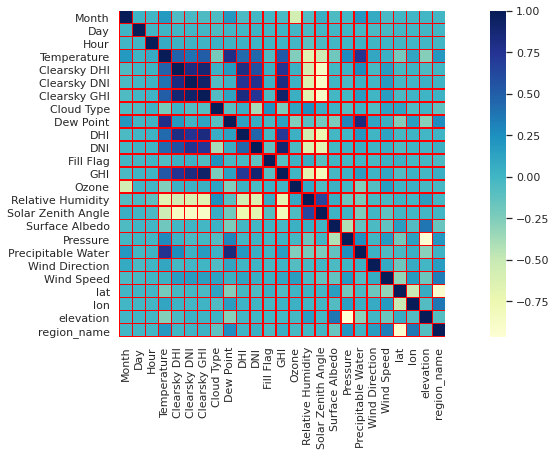

In [ ]:
plt.figure(figsize=(16,6))
sns.heatmap(df.drop(columns=['Year','Minute']).corr(),cmap="YlGnBu",square=True,linewidths=.5,center=0,linecolor="red")

Some correlations are: 

*   The solar zenith angle and the irradiance
*   The humidity and the irradiance
*   The direct normal irradiance and the cloud type



### Clouds

The next graph shows how much DNI is influenced by the cloud type

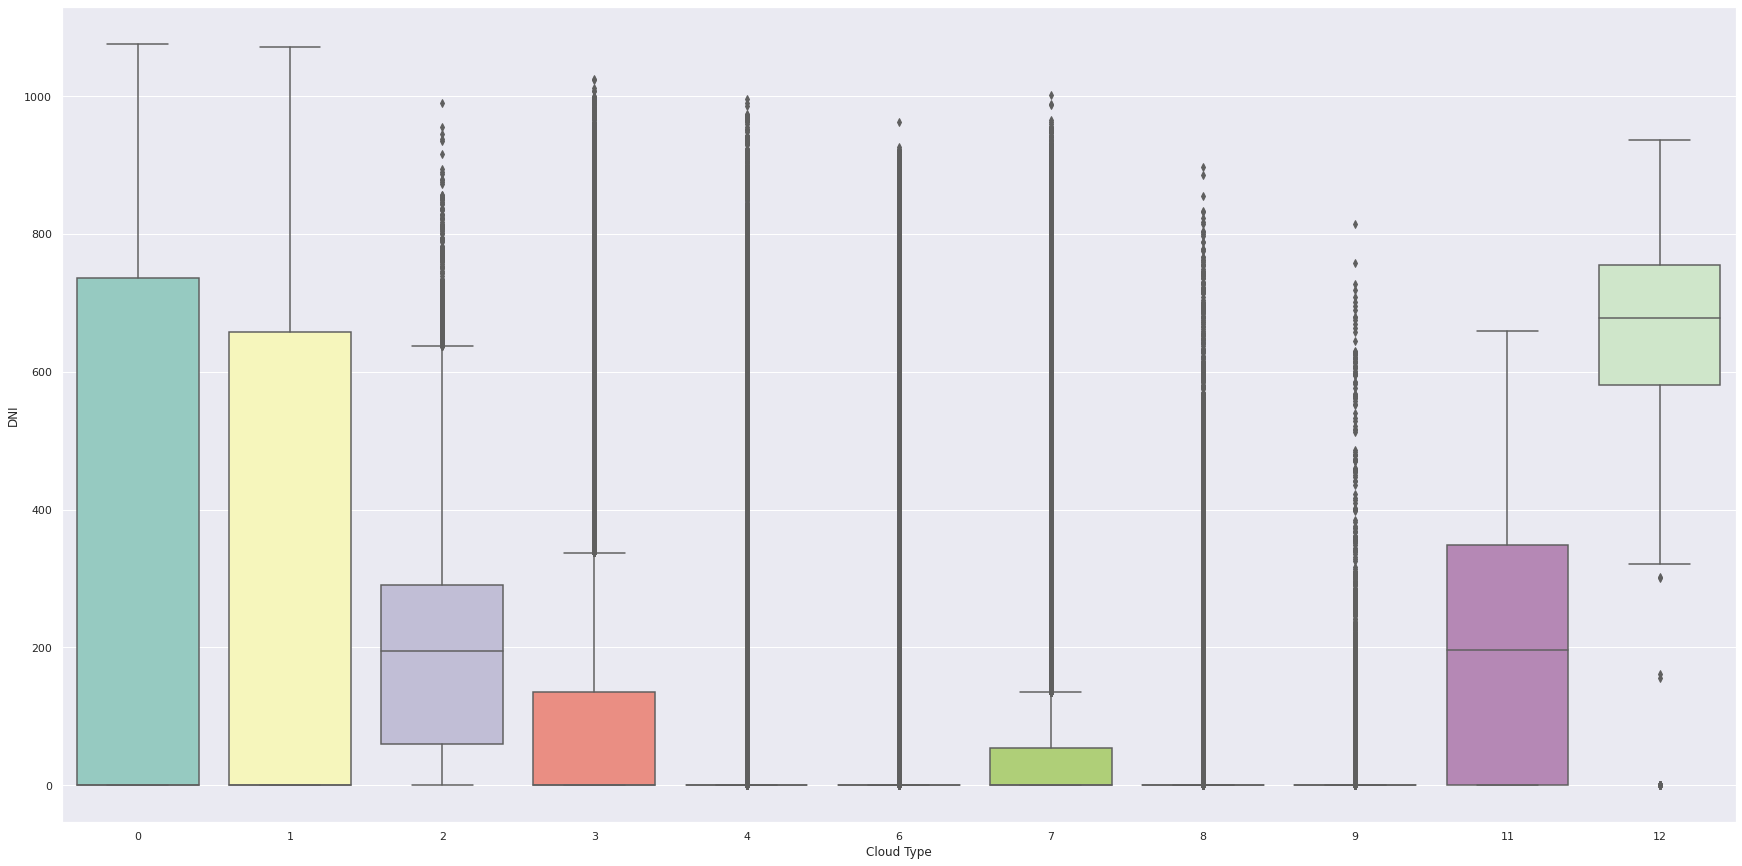

In [ ]:
plt.figure(figsize=(30,15))
sns.boxplot(data=df,y=df.DNI,x=df['Cloud Type'],palette="Set3")

Cloud type 12 is a positive influence, but it should be noted that is a little part of the data and so isn't much reliable 

Move this in the data distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f532dcc50>]],
      dtype=object)

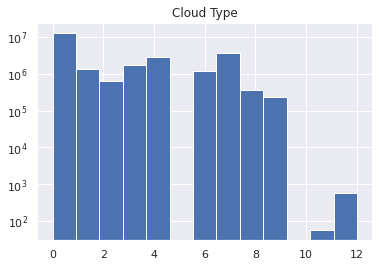

In [ ]:
df.hist(column='Cloud Type', log=True, bins=13)

### Humidity

This is how the humidity influences DNI

In [ ]:
#Group the humidity values into multiples of ten (instead of float numbers)
df['Relative Humidity']=df['Relative Humidity'].apply(lambda x: 10*(x//10) if x > 1 else 0)

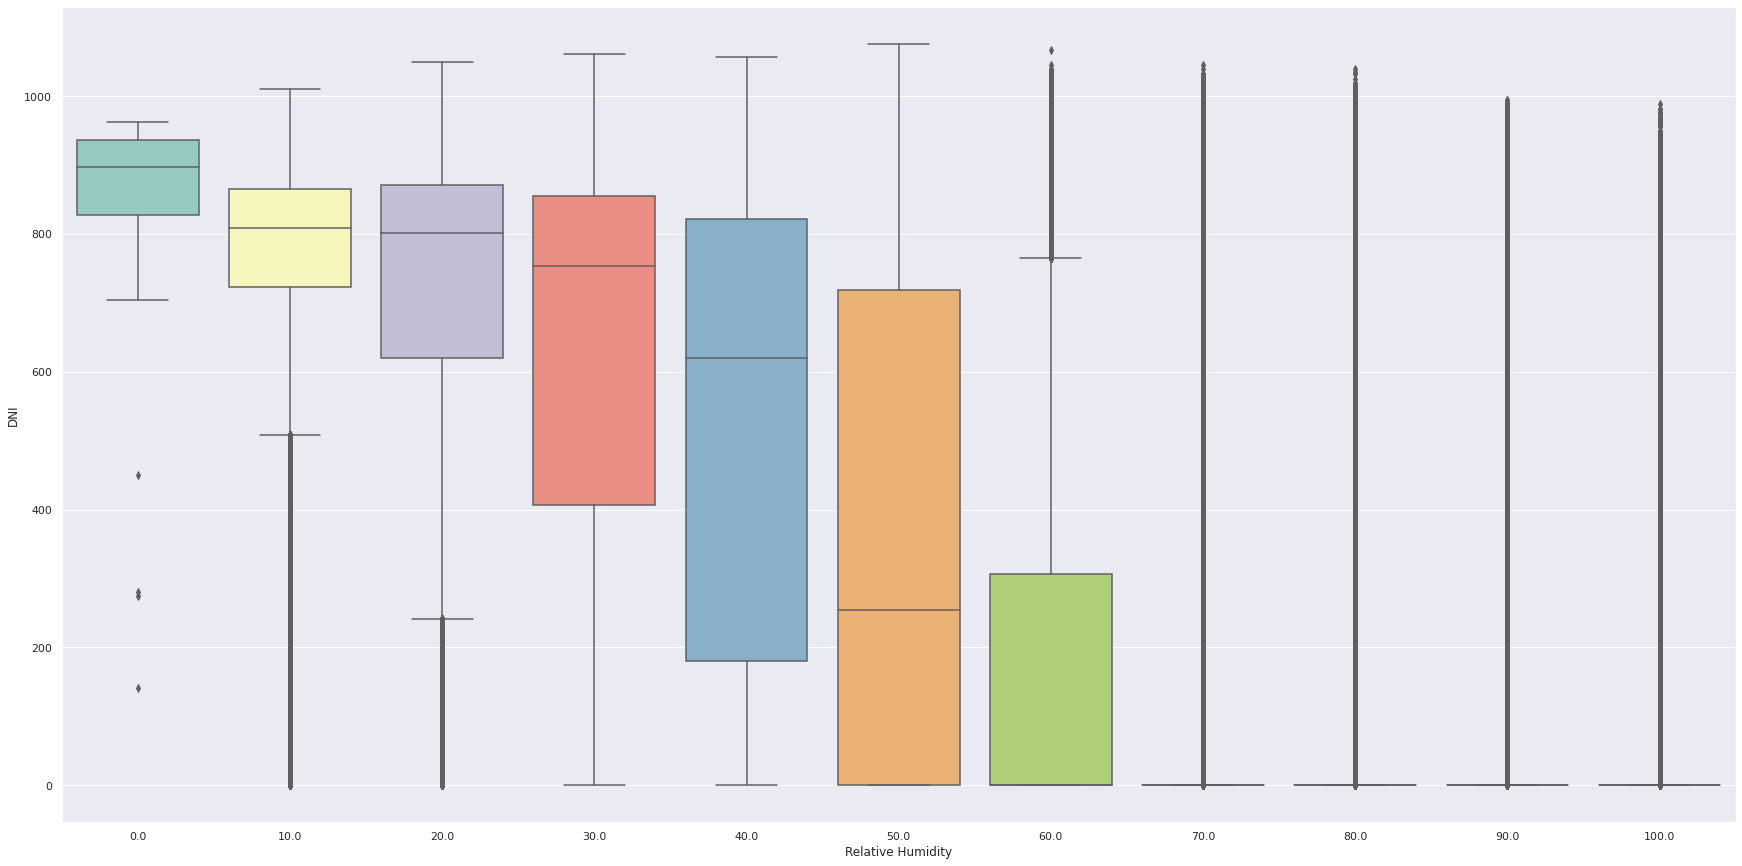

In [ ]:
plt.figure(figsize=(30,15))
sns.boxplot(data=df,y=df.DNI,x=df['Relative Humidity'],palette="Set3")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d999565d0>]],
      dtype=object)

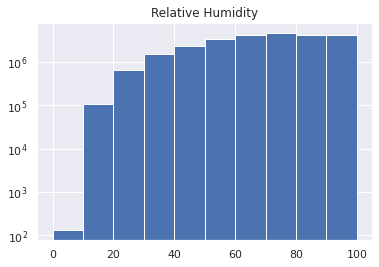

In [ ]:
df.hist(column='Relative Humidity', log=True)

### Solar zenith angle

This is how the solar zenith angle influences DNI. At its minimum it's solar noon, and at its maximum is solar midnight; around 90° degrees, rays stop touching the surface 

In [ ]:
#The solar zenith is group into angles of 5 degrees difference <-------- rewrite in better english
df['Solar Zenith Angle']=df['Solar Zenith Angle'].apply(lambda x: 5*(x//5) if x > 1 else 0)

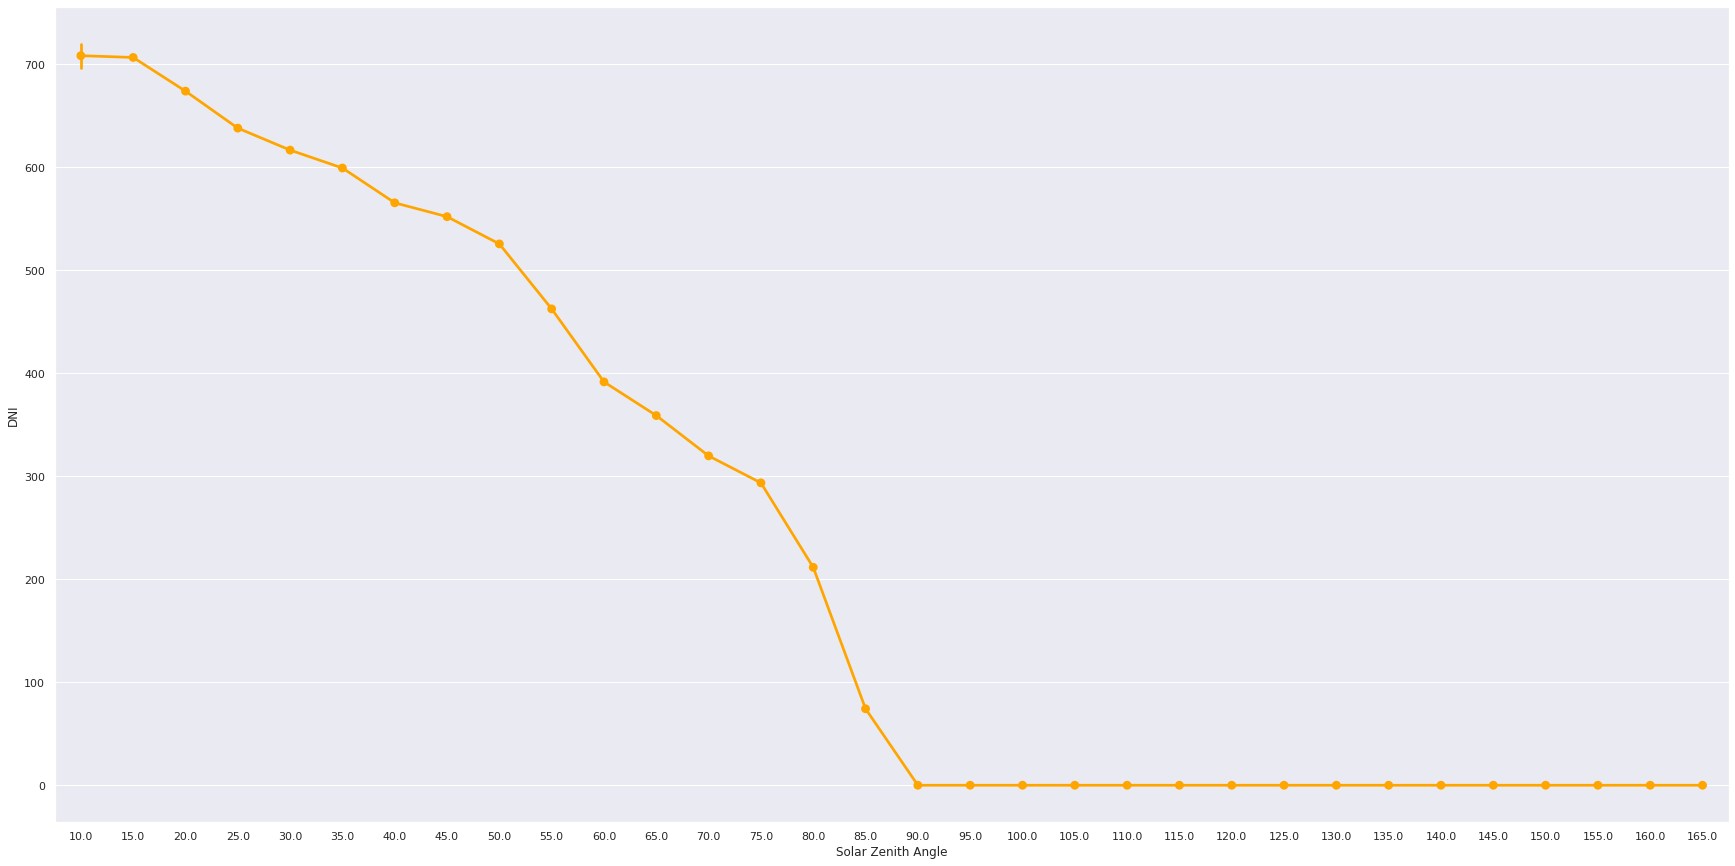

In [ ]:
plt.figure(figsize=(30,15))
sns.pointplot(data=df,y=df.DNI,x=df['Solar Zenith Angle'],color="Orange")

### Months

And of course, it depends on the season

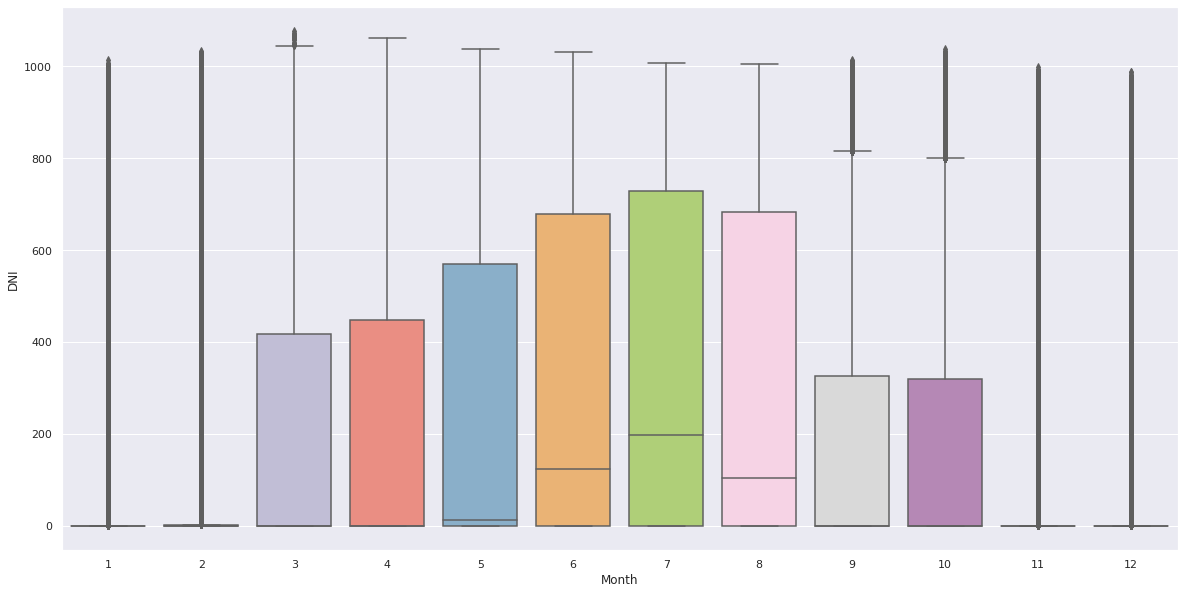

In [ ]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df,y=df.DNI,x=df['Month'],palette="Set3")

## 2.3 Data distribution

Load the dataset

In [ ]:
#Read the data
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/solar_irr_pred/final.csv")

In [ ]:
#Imports to plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<h1> Analyze the distribution of DNI

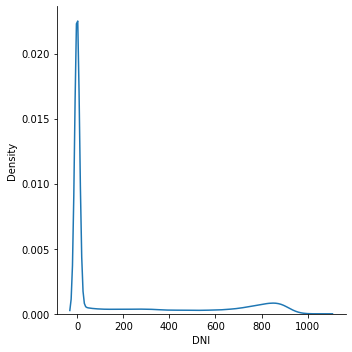

In [ ]:
# Density Plot of DNI
sns.displot(data=df, x=df['DNI'], kind = "kde") 

In [ ]:
# 60% of the data has DNI = 0
df2 = pd.read_csv("/content/drive/MyDrive/solar_irr_pred/final.csv", usecols = ["DNI"])
ls = df2.values.tolist()
cnt = ls.count([0])
print("Values smaller than 100 compose {:.2f}% of the dataset".format(cnt*100/len(ls)))

Value smaller than 100 are 60.18% of the dataset


<h3> 60% of the dataset has DNI value < 100 </h3>

<h2> Here is shown the probability of DNI values given the season </h2>

In [ ]:
#Drop values smaller than 100 so the plots will be more readable 
df = df[df.DNI > 100]

#Map moth to season
df['Month'] =df['Month'].map({1:"winter", 2: "winter", 3: "spring", 4:"spring", 5: "spring", 6:"summer", 7: "summer", 8: "summer", 9:"fall", 10:"fall", 11:"fall", 12:"winter"})

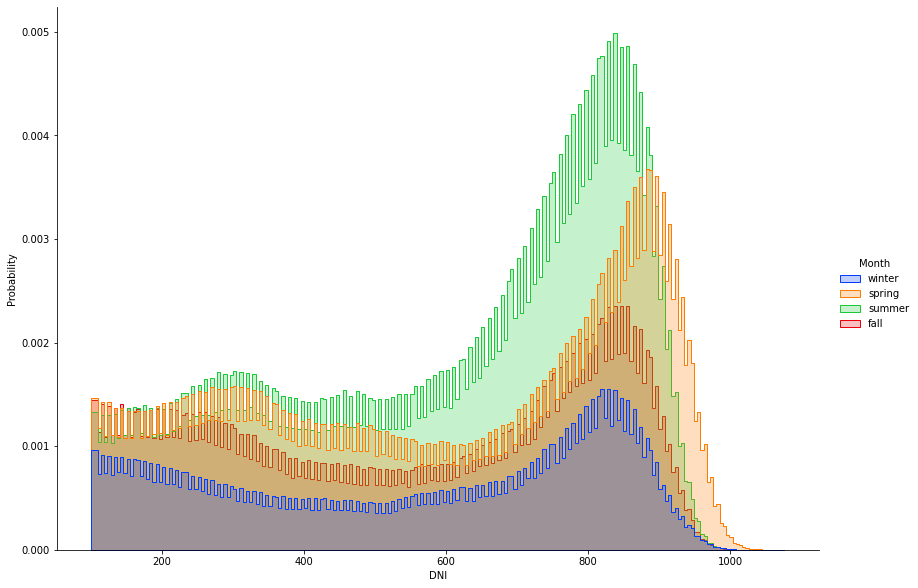

In [ ]:
# Probability of DNI given the season

sns.displot(data=df, x = df['DNI'], hue ="Month",element="step", height=8.27, aspect=11.7/8.27, stat="probability") 

<h2> But what mostly influences DNI is the solar zenith angle </h2>

In [ ]:
#Convert solar zenith angle values to the nearest multiple of 5
# 1.2, 2.3, ... 88.9 --------> 0, 5, ... 90
df['Solar Zenith Angle']=df['Solar Zenith Angle'].apply(lambda x: 5*(x//5) if x > 1 else 0)

Here i generated an ECDF graph to actually show how DNI is highly affected by the zenith angle, and how potentially high can it be given the angle

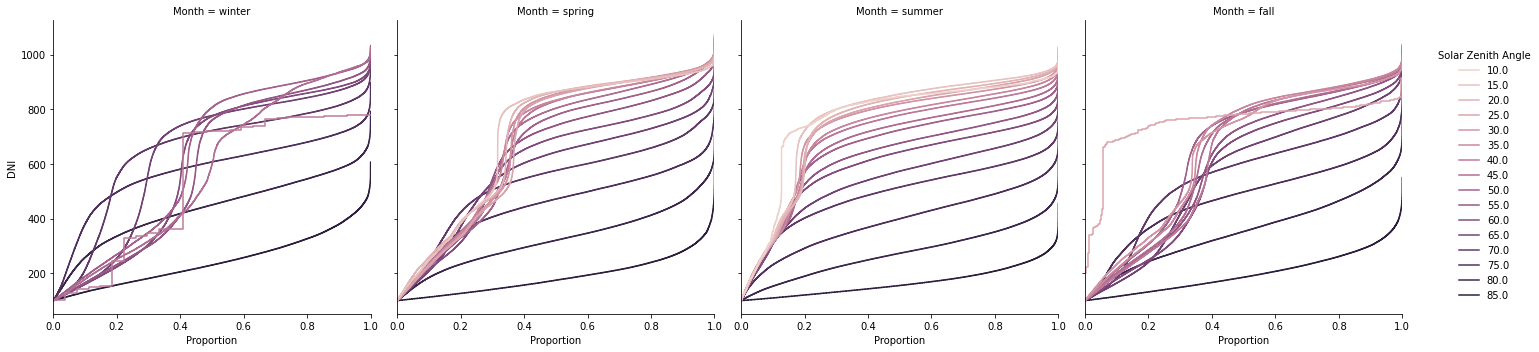

In [ ]:
#
sns.displot(data=df, y= df['DNI'], hue ="Solar Zenith Angle", col="Month", kind = "ecdf")

<h1> Nonetheless, Solar Zenith is not the only factor; meawhile on higher degrees (remember, higher the zenith, less the sunray that arrive) the trend of DNI is somewhat constant, on lower degrees it's crearly influenced by other factors </h1>

# 3 Training

## Preliminary steps

### Mount drive and start the spark session

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar -xvf spark-3.1.2-bin-hadoop2.7.tgz  &> /dev/null

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
from google.colab import files
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder\
.master("local[*]") \
.config("spark.driver.memory", "15g")\
.config("spark.executor.memory", "10g")\
.config("spark.executor.extraJavaOptions", "-XX:-UseGCOverheadLimit")\
.config("spark.driver.maxResultSize", "10g")\
.getOrCreate()

In [ ]:
spark

### Load the dataset

In [ ]:
#Where to save the model
path = "/content/drive/MyDrive/solar_irr_pred/"

In [ ]:
filename = ""

In [ ]:
# Loading the data. at this point they're already shuffled
data = spark.read.load("/content/drive/MyDrive/solar_irr_pred/shuffled.csv", format="csv", header=True)

Some columns are not useful, such as the year and the minute (they're constant)

In [ ]:
data = data.drop("Year")
data = data.drop("Minutes")

In [ ]:
#Remove features that are too correlated
data = data.drop("GHI")
data = data.drop("DHI")
#data = data.drop("DNI")
data = data.drop("Clearsky GHI")
data = data.drop("Clearsky DNI")
data = data.drop("Clearsky DHI")


In [ ]:
#Convert types (inferschema fails  often)
data = data.withColumn(colName="Month", col=data["Month"].cast("Int"))
data = data.withColumn(colName="Day", col=data["Day"].cast("Int"))
data = data.withColumn(colName="Hour", col=data["Hour"].cast("Int"))
data = data.withColumn(colName="Temperature", col=data["Temperature"].cast("Double"))
data = data.withColumn(colName="Cloud Type", col=data["Cloud Type"].cast("int"))
data = data.withColumn(colName="Dew Point", col=data["Dew Point"].cast("Double"))
data = data.withColumn(colName="Fill Flag", col=data["Fill Flag"].cast("Int"))
data = data.withColumn(colName="Ozone", col=data["Ozone"].cast("Double"))
data = data.withColumn(colName="Relative Humidity", col=data["Relative Humidity"].cast("Double"))
data = data.withColumn(colName="Solar Zenith Angle", col=data["Solar Zenith Angle"].cast("Double"))
data = data.withColumn(colName="Surface Albedo", col=data["Surface Albedo"].cast("Double"))
data = data.withColumn(colName="Pressure", col=data["Pressure"].cast("Double"))
data = data.withColumn(colName="Precipitable Water", col=data["Precipitable Water"].cast("Double"))
data = data.withColumn(colName="Wind Direction", col=data["Wind Direction"].cast("Int"))
data = data.withColumn(colName="Wind Speed", col=data["Wind Speed"].cast("Double"))
data = data.withColumn(colName="lat", col=data["lat"].cast("Double"))
data = data.withColumn(colName="lon", col=data["lon"].cast("Double"))
data = data.withColumn(colName="Elevation", col=data["Elevation"].cast("Int"))
data = data.withColumn(colName="region_name", col=data["region_name"].cast("Int"))
data = data.withColumn(colName="DNI", col=data["DNI"].cast("Int"))

### Load the dataset with 90% of values with solar zenith angle >= 90 removed

In [ ]:
path = "/content/drive/MyDrive/solar_irr_pred/"

In [ ]:
filename = "Sampled_zenith"

In [ ]:
data = spark.read.load("/content/drive/MyDrive/solar_irr_pred/shuffled.csv", format="csv", header=True)

In [ ]:
from pyspark.sql import functions as f

In [ ]:
#https://stackoverflow.com/questions/51565395/pyspark-create-new-column-and-fill-in-based-on-conditions-of-two-other-columns
data = data.withColumn(
    "bigger_90", 
    f.when(data["Solar Zenith Angle"]>= 90, 1)\
    .when(data["Solar Zenith Angle"] < 90, 0)
    )

In [ ]:
data = data.sampleBy("bigger_90", fractions={0: 0.9, 1: 0.1}, seed=0)

In [ ]:
data = data.drop("Year")
data = data.drop("Minutes")

In [ ]:
#Remove features that are too correlated
data = data.drop("GHI")
data = data.drop("DHI")
#data = data.drop("DNI")
data = data.drop("Clearsky GHI")
data = data.drop("Clearsky DNI")
data = data.drop("Clearsky DHI")
data = data.drop("bigger_90")

In [ ]:
#Convert types (inferschema fails  often)
data = data.withColumn(colName="Month", col=data["Month"].cast("Int"))
data = data.withColumn(colName="Day", col=data["Day"].cast("Int"))
data = data.withColumn(colName="Hour", col=data["Hour"].cast("Int"))
data = data.withColumn(colName="Temperature", col=data["Temperature"].cast("Double"))
data = data.withColumn(colName="Cloud Type", col=data["Cloud Type"].cast("int"))
data = data.withColumn(colName="Dew Point", col=data["Dew Point"].cast("Double"))
data = data.withColumn(colName="Fill Flag", col=data["Fill Flag"].cast("Int"))
data = data.withColumn(colName="Ozone", col=data["Ozone"].cast("Double"))
data = data.withColumn(colName="Relative Humidity", col=data["Relative Humidity"].cast("Double"))
data = data.withColumn(colName="Solar Zenith Angle", col=data["Solar Zenith Angle"].cast("Double"))
data = data.withColumn(colName="Surface Albedo", col=data["Surface Albedo"].cast("Double"))
data = data.withColumn(colName="Pressure", col=data["Pressure"].cast("Double"))
data = data.withColumn(colName="Precipitable Water", col=data["Precipitable Water"].cast("Double"))
data = data.withColumn(colName="Wind Direction", col=data["Wind Direction"].cast("Int"))
data = data.withColumn(colName="Wind Speed", col=data["Wind Speed"].cast("Double"))
data = data.withColumn(colName="lat", col=data["lat"].cast("Double"))
data = data.withColumn(colName="lon", col=data["lon"].cast("Double"))
data = data.withColumn(colName="Elevation", col=data["Elevation"].cast("Int"))
data = data.withColumn(colName="region_name", col=data["region_name"].cast("Int"))
data = data.withColumn(colName="DNI", col=data["DNI"].cast("Int"))

### (optional) Remove rare clud types

inconclusive

In [ ]:
data = data[data["Cloud Type"] < 10]

In [ ]:
# ex spinoff_
filename+="Removed_cloud"

## 3.1 Decision tree

In [ ]:
# Various imports
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.context import SparkContext

In [ ]:
# 
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=[ 'Month', 'Day', 'Hour', 'Temperature', 'Cloud Type', 'Dew Point',  'Fill Flag', 'Ozone', 'Relative Humidity', 'Solar Zenith Angle', 'Surface Albedo', 'Pressure', 'Precipitable Water', 'Wind Direction', 'Wind Speed', 'lat', 'lon', 'Elevation','region_name'],outputCol="features")

In [ ]:
# Avoids some problem with the cross validating model

data = data.withColumnRenamed(existing="DNI", new = "label")

In [ ]:
data_2 = assembler.transform(data)

In [ ]:
'''from pyspark.ml.regression import DecisionTreeRegressor
rf = DecisionTreeRegressor(labelCol="label", featuresCol="features")'''

'from pyspark.ml.regression import DecisionTreeRegressor\nrf = DecisionTreeRegressor(labelCol="label", featuresCol="features")'

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator


# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=13).fit(data_2)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data_2.randomSplit([0.7, 0.3])



In [ ]:
# Train a DecisionTree model.
dt = DecisionTreeRegressor(featuresCol="indexedFeatures", maxDepth=10)

# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, dt])

# Train model.  This also runs the indexer.
model = pipeline.fit(trainingData)


Save model

In [ ]:
model.save(path+"10d_decision_tree_reg_"+filename)

Reload model

In [ ]:
from pyspark.ml import PipelineModel

model = PipelineModel.load("/content/drive/MyDrive/solar_irr_pred/10d_decision_tree_reg_Sampled_zenith")

--------------------------

In [ ]:
df = model.transform(data_2).select('label', 'Month', 'Hour', 'lat', 'lon', 'region_name').toPandas()

In [ ]:
df.to_csv("/content/drive/MyDrive/solar_irr_pred/bestTree_dataset_pred.csv", index=False)

----------------------------------

#### Evaluation

In [ ]:
predictions = model.transform(testData)

In [ ]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rmse #94.28522773074752

75.51145422974524

In [ ]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
r2 #0.923754276957762

0.9523981138977139

In [ ]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
mse #8889.70416823892

5701.979719890911

In [ ]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
mae #67.54735017466157

48.50754908415043

In [ ]:
rfResult = predictions.select("label","prediction").toPandas()

In [ ]:
#TODO: same plot as above without outliers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Plotting library
import seaborn as sns   # Plotting library
from scipy.stats import gaussian_kde
plt.rcParams['agg.path.chunksize'] = 10000

In [ ]:
xmin = min(rfResult.prediction)
xmax = max(rfResult.prediction)
ymin = min(rfResult.label)
ymax = max(rfResult.label)

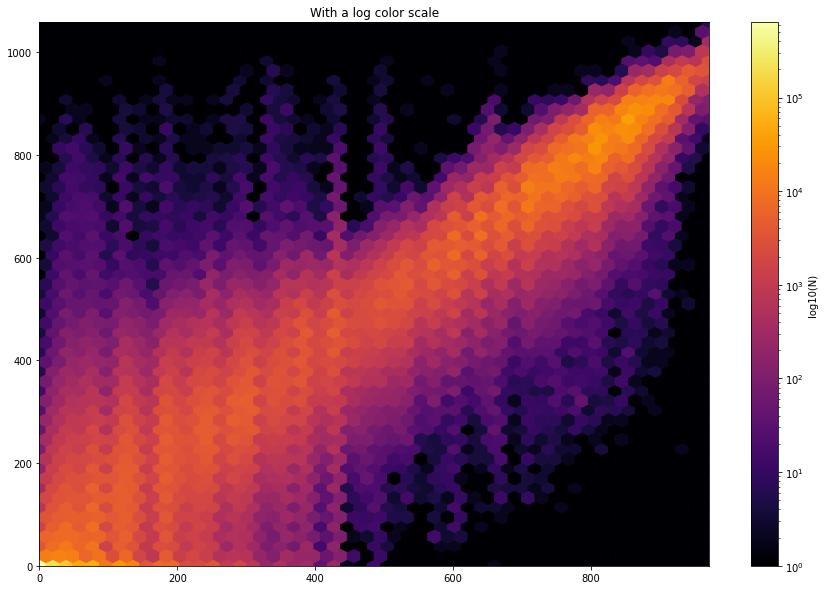

In [ ]:
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(15, 10))


hb = ax.hexbin(rfResult.prediction, rfResult.label, gridsize=50, bins='log', cmap='inferno')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("With a log color scale")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')

plt.show()

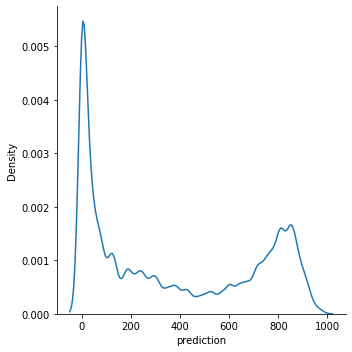

In [ ]:
# Density Plot of DNI
sns.displot(data=rfResult, x=rfResult["prediction"], kind = "kde") 

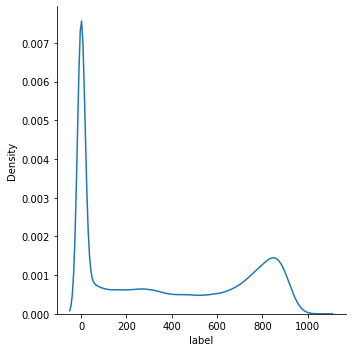

In [ ]:
# Density Plot of DNI
sns.displot(data=rfResult, x=rfResult.label, kind = "kde") 

Remove dni < 100 to have a better look

In [ ]:
rfResult = rfResult[rfResult["label"] > 100]

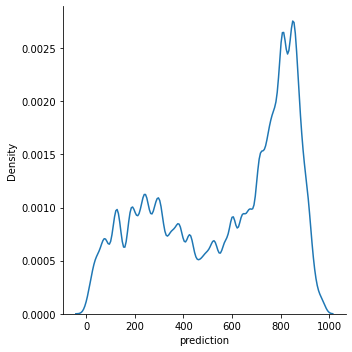

In [ ]:
# Density Plot of DNI
sns.displot(data=rfResult, x=rfResult["prediction"], kind = "kde") 

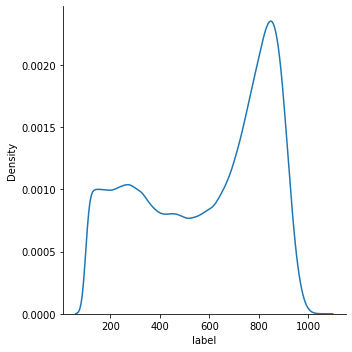

In [ ]:
# Density Plot of DNI
sns.displot(data=rfResult, x=rfResult.label, kind = "kde") 



## 3.2 Random forest regression

### Decide number of trees and depth

Lower number of trees and high depth is preferred, to the point that a single decision tree is the best. A bigger forest tends to give too much importance to a single feature (Cloud Type), resulting in worst performance.

Hyperparameter tuning

In [ ]:
# Various imports
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.context import SparkContext

In [ ]:
# 
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=[ 'Month', 'Day', 'Hour', 'Temperature', 'Cloud Type', 'Dew Point',  'Fill Flag', 'Ozone', 'Relative Humidity', 'Solar Zenith Angle', 'Surface Albedo', 'Pressure', 'Precipitable Water', 'Wind Direction', 'Wind Speed', 'lat', 'lon', 'Elevation','region_name'],outputCol="features")

In [ ]:
# Avoids some problem with the cross validating model

data = data.withColumnRenamed(existing="DNI", new = "label")

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(labelCol="label", featuresCol="features", numTrees= 20, maxDepth=5)

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[assembler, rf])

<h2 >Initialize the parameter grid to explore; the parameters are: the number of trees and depth </h2>

The forest has been tested for a number of trees between 50 and 1000, each one with a depth starting from 5 to 10.  

In [ ]:

from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
paramGrid = ParamGridBuilder()\
.addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)])\
.addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 10, num = 8)])\
.build()
# More than 10 depth crashes java

Initialize the cross validator

In [ ]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)
                        

Split data

In [ ]:
# Splitting the data

(trainingData, testData) = data.randomSplit([0.7, 0.3])

Actual fitting

In [ ]:
cvModel = crossval.fit(trainingData)

Saving

In [ ]:
cvModel.save(path+"forest_"+"to1000_10_best_model"+filename)

### Reload the best model and evaluate

Preparing data

In [ ]:
# Various imports
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.context import SparkContext
import numpy as np

In [ ]:
# 
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=[ 'Month', 'Day', 'Hour', 'Temperature', 'Cloud Type', 'Dew Point',  'Fill Flag', 'Ozone', 'Relative Humidity', 'Solar Zenith Angle', 'Surface Albedo', 'Pressure', 'Precipitable Water', 'Wind Direction', 'Wind Speed', 'lat', 'lon', 'Elevation','region_name'],outputCol="features")

In [ ]:
# Avoids some problem with the cross validating model

data = data.withColumnRenamed(existing="DNI", new = "label")

Hyperparameter tuning

In [ ]:
# Splitting the data
# 
(trainingData, testData) = assembler.transform(data).randomSplit([0.7, 0.3])

Reloading the previous computed model


In [ ]:
from pyspark.ml.tuning import CrossValidatorModel
cvModel = CrossValidatorModel.load("/content/drive/MyDrive/solar_irr_pred/forest_to50_t010_best_modelSampled_zenith")

In [ ]:
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[1]

In [ ]:
print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))

numTrees -  32
maxDepth -  10


Making predictions

In [ ]:
predictions = cvModel.transform(testData)

In [ ]:
#40 t 10 d 78.49746004480447 - 0.9471397217579982 - 6161.851233485675 - 55.52664385551452 

In [ ]:
#32 t 10 d 76.34361789297733 -0.951343110846033 - 5828.34799298893 - 52.225695780696725 (optimal)

#### Evaluation

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rmse #117.02869831150794 - 114.08779223766399 - 77.92563614880603

76.34361789297733

In [ ]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
r2 #0.8824287803289528 - 0.8883108492315843 - 0.9478833955696069

0.951343110846033

In [ ]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
mse #13695.716228485942 - 0.8883108492315843 - 6072.404769196108

5828.34799298893

In [ ]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
mae #93.82684325509706 - 90.53354998008827 - 54.74606670438182

52.225695780696725

This cell is to evaluate only a small sample of data, so graphs don't take that long to generate; of course, they're less precise

In [ ]:
'''
# 
rfPred = cvModel.transform(data)

rfResult1 = rfPred.sample(0.3)
#rfResult = rfResult1.select("Prediction", "label").toPandas() #to select only prediction - target
rfResult = rfResult1.toPandas()
'''

'# Remove later this cursed code\n#code removed\nrfPred = cvModel.transform(data)\n\nrfResult1 = rfPred.sample(0.3)\n#rfResult = rfResult1.select("Prediction", "label").toPandas()\nrfResult = rfResult1.toPandas()\n'

In [ ]:
rfResult = predictions.select("Prediction", "label").toPandas() #select only predictions and the target

In [ ]:
#Imports to plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Plotting library
import seaborn as sns   # Plotting library
from scipy.stats import gaussian_kde
plt.rcParams['agg.path.chunksize'] = 10000

<h2> The following plot is a heatmap to have an idea on how DNI values are predicted vs how actually are. </h2>

In [ ]:
xmin = min(rfResult.Prediction)
xmax = max(rfResult.Prediction)
ymin = min(rfResult.label)
ymax = max(rfResult.label)

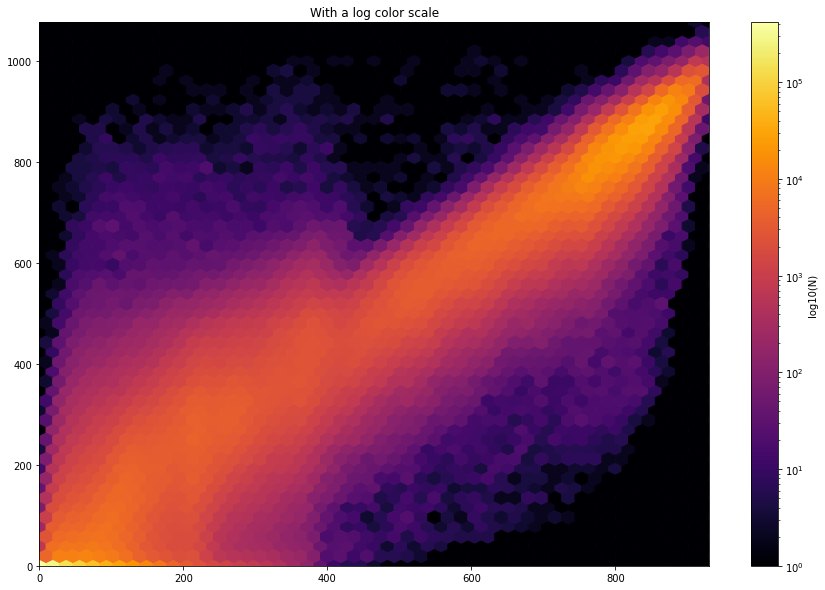

In [ ]:
#i created this plot following this example on matplotlib site:
#https://matplotlib.org/2.0.2/examples/pylab_examples/hexbin_demo.html

fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(15, 10))


hb = ax.hexbin(rfResult.Prediction, rfResult.label, gridsize=50, bins='log', cmap='inferno')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("With a log color scale")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')

plt.show()

I decided to use a heatmap because the dataset is very large, and a log scale is the best to represent so many points

<h2> Hereare shown the most influent features i the forest <h2>

Text(0.5, 1.0, 'Feature Importance')

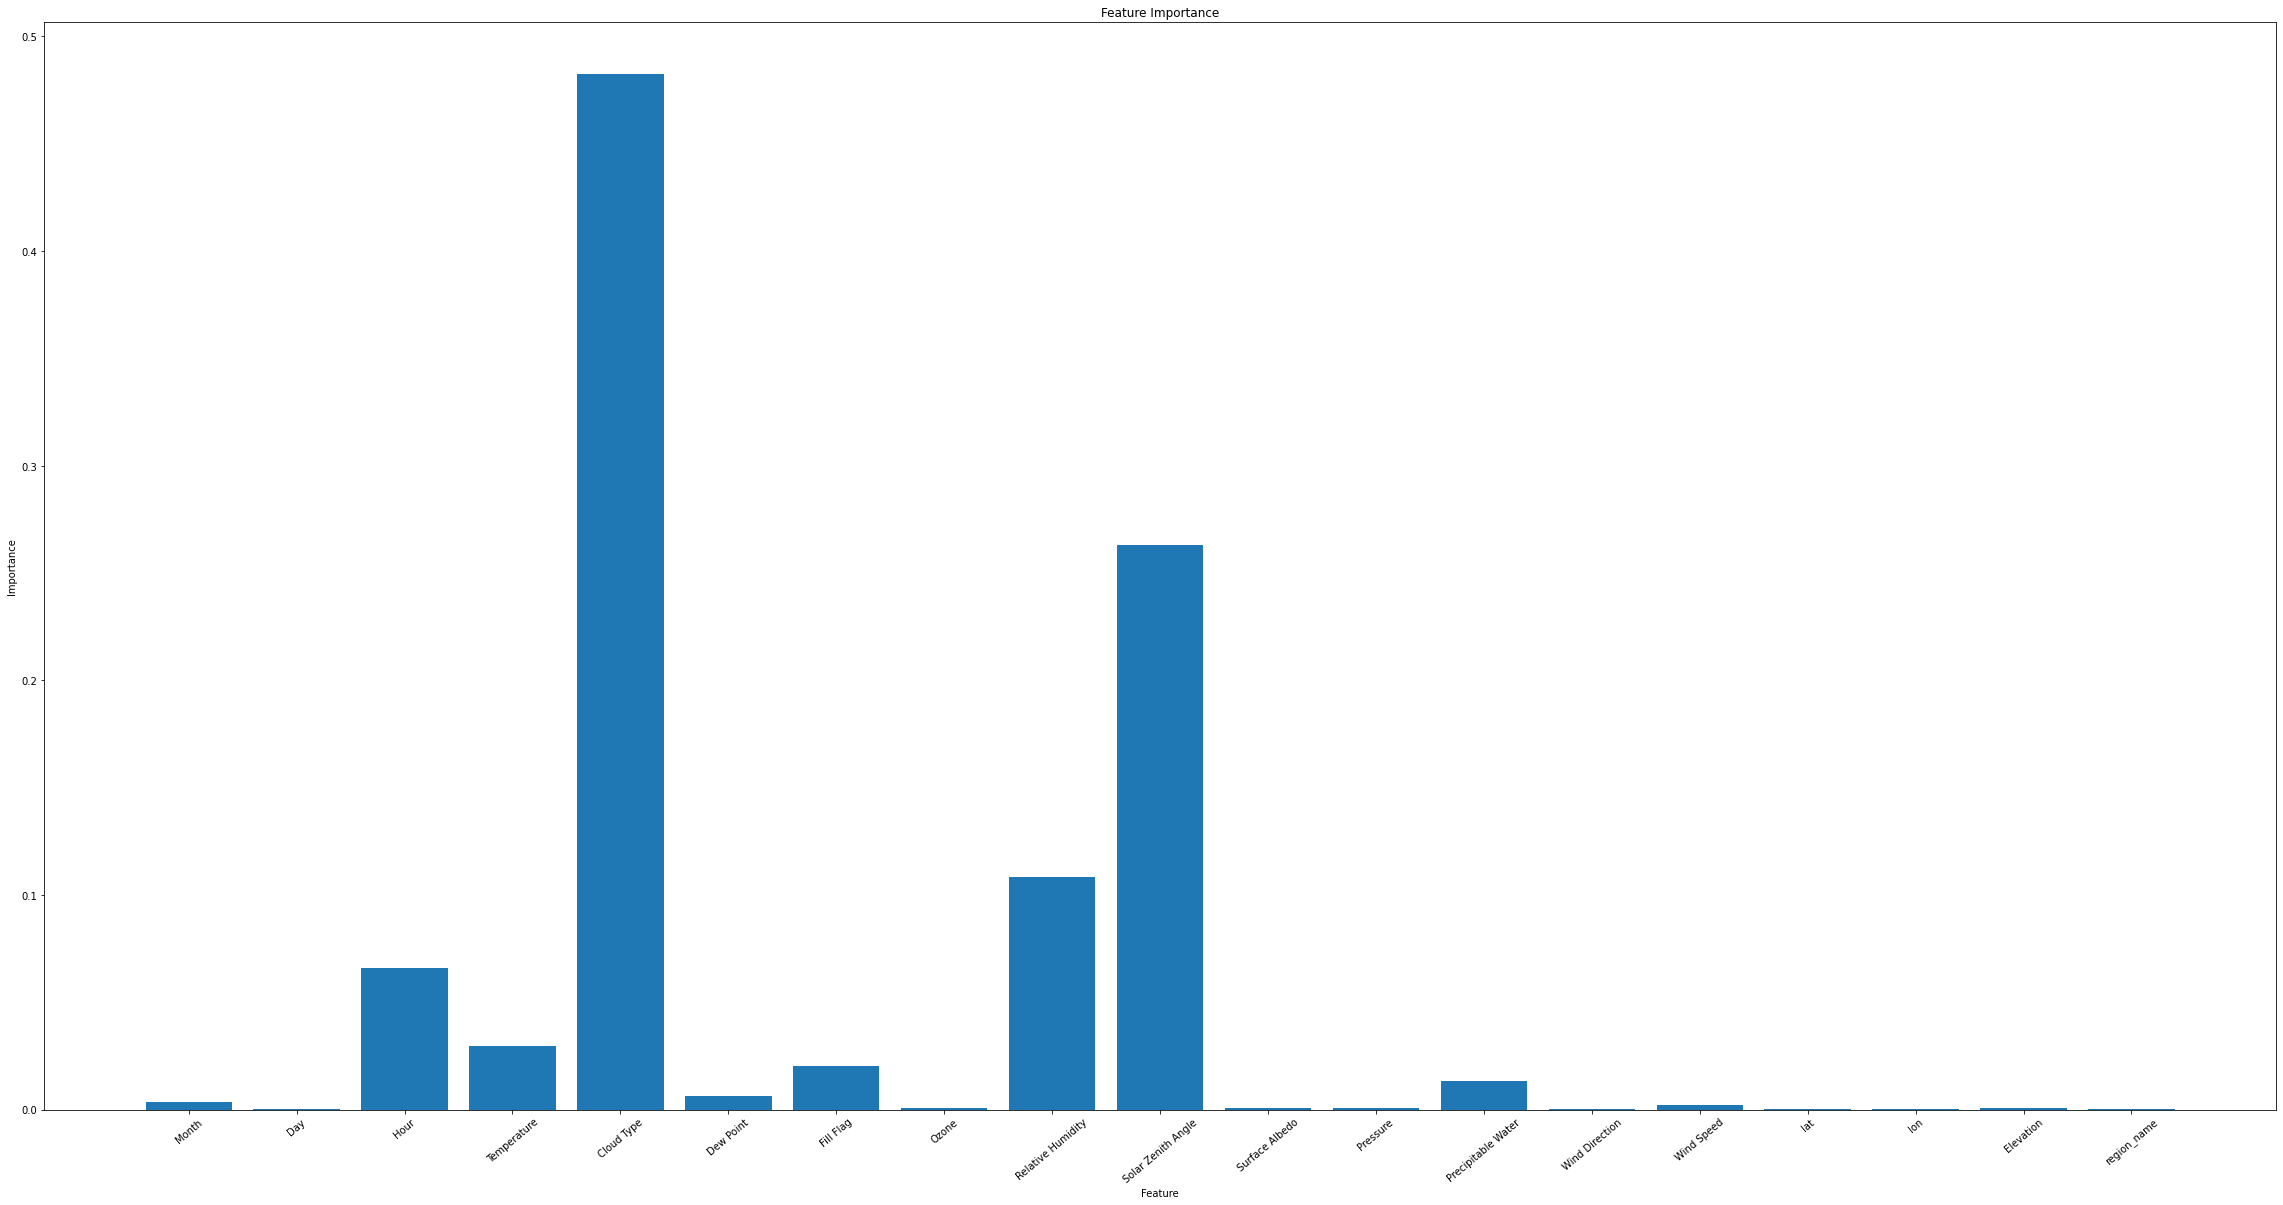

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Plotting library
import seaborn as sns   # Plotting library
plt.figure(figsize=(40,20))
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[1]
importances = bestModel.featureImportances
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
feature_list=[ 'Month', 'Day', 'Hour', 'Temperature', 'Cloud Type', 'Dew Point',  'Fill Flag', 'Ozone', 'Relative Humidity', 'Solar Zenith Angle', 'Surface Albedo', 'Pressure', 'Precipitable Water', 'Wind Direction', 'Wind Speed', 'lat', 'lon', 'Elevation','region_name']
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importance')

<h3> The predicted distribution of data is very similar to the actual one </h3>

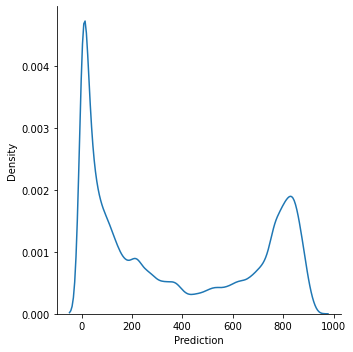

In [ ]:
# Density Plot of DNI
sns.displot(data=rfResult, x=rfResult["Prediction"], kind = "kde") 

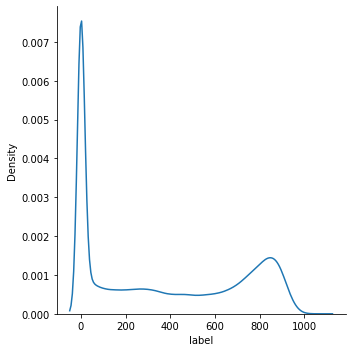

In [ ]:
# Density Plot of DNI
sns.displot(data=rfResult, x=rfResult.label, kind = "kde") 

In [ ]:
rfResult.head()

,Prediction,label
0,1.123001,0
1,0.685061,0
2,1.120777,0
3,1.952406,0
4,0.002701,0


Remove dni < 100 to have a better look

In [ ]:
rfResult = rfResult[rfResult["label"] > 100]

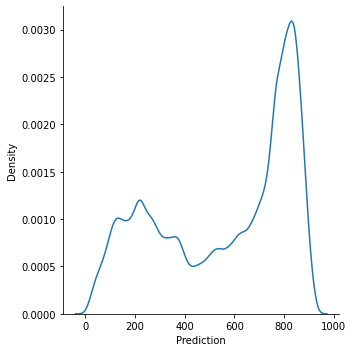

In [ ]:
# Density Plot of DNI
sns.displot(data=rfResult, x=rfResult["Prediction"], kind = "kde") 

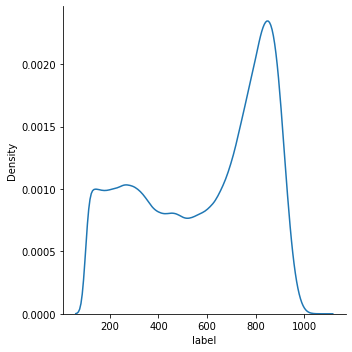

In [ ]:
# Density Plot of DNI
sns.displot(data=rfResult, x=rfResult.label, kind = "kde") 

## 3.3 Linear regression

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.context import SparkContext

In [ ]:
from pyspark.ml.regression import LinearRegression

# Load training data
#training = spark.read.load("/content/drive/MyDrive/solar_irr_pred/final.csv", format="csv", header=True)

feature_columns = data.select([ 'Month', 'Day', 'Hour', 'Temperature', 'Cloud Type', 'Dew Point',  'Fill Flag', 'Ozone', 'Relative Humidity', 'Solar Zenith Angle', 'Surface Albedo', 'Pressure', 'Precipitable Water', 'Wind Direction', 'Wind Speed', 'lat', 'lon', 'Elevation','region_name']) # here we omit the final columnfrom pyspark.ml.feature import VectorAssemblerassembler = VectorAssembler(inputCols=feature_columns,outputCol="features")

In [ ]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=[ 'Month', 'Day', 'Hour', 'Temperature', 'Cloud Type', 'Dew Point',  'Fill Flag', 'Ozone', 'Relative Humidity', 'Solar Zenith Angle', 'Surface Albedo', 'Pressure', 'Precipitable Water', 'Wind Direction', 'Wind Speed', 'lat', 'lon', 'Elevation','region_name'],outputCol="features")

In [ ]:
data_2 = assembler.transform(data)

Optional: standardize features; yields slightly better results

In [ ]:
#Standardization
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(data_2)

# Normalize each feature to have unit standard deviation.
data_2 = scalerModel.transform(data_2)
filename=filename+"standard"

Optional: normalize features; yields slightly better results, but worst than standardization

In [ ]:
'''#Normalization
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import Normalizer

# Normalize each Vector using $L^1$ norm.
normalizer = Normalizer(inputCol="features", outputCol="normFeatures")
#data_2 = normalizer.transform(data_2)
# Normalize each Vector using $L^\infty$ norm.
data_2 = normalizer.transform(data_2, {normalizer.p: float("inf")})
filename=filename+"normalized"

#----------------'''

In [ ]:
train, test = data_2.randomSplit([0.7, 0.3])

Actual fitting

In [ ]:
from pyspark.ml.regression import LinearRegression
algo = LinearRegression(featuresCol="features", labelCol="DNI")
model = algo.fit(train)

Save values

In [ ]:
model.save(path+"regression_model_"+filename)

Reload values

In [ ]:
from pyspark.ml.regression import  LinearRegressionModel
model =  LinearRegressionModel.load("/content/drive/MyDrive/solar_irr_pred/regression_model_Sampled_zenithstandard")

In [ ]:
df = model.transform(data_2).select('prediction', 'Month', 'Hour', 'lat', 'lon', 'region_name').toPandas()

In [ ]:
df.to_csv("/content/drive/MyDrive/solar_irr_pred/bestSimpleRegression_dataset_pred.csv", index = False)

#### Evaluation

In [ ]:
evaluation_summary = model.evaluate(test)

In [ ]:
evaluation_summary.meanAbsoluteError 

163.214880210381

In [ ]:
evaluation_summary.meanSquaredError


38714.20538850823

In [ ]:
evaluation_summary.r2

0.6767294041965961

In [ ]:
evaluation_summary.rootMeanSquaredError

196.759257440427

In [ ]:
predictions = model.transform(test)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Plotting library
import seaborn as sns   # Plotting library
df2 = predictions.select("prediction", "DNI").toPandas()

In [ ]:
print("Intercept: " + str(model.intercept))
print("Coefficient: " + str(model.coefficients))

Intercept: 18.969174435859973
Coefficient: [-1.1880306259045907,0.12351000895842848,-1.217016691314335,7.47140381344084,-59.28310256992641,-1.68023217102767,-13.381537151198978,-474.52763599717,-1.9821555400018034,-5.557741234704731,17.1249675566081,0.8642177852651429,-101.59404267272814,0.012298542540774358,-2.910854568633977,7.8116522957015295,-1.2229430881335037,0.08205479847918665,1.3159786044746862]


In [ ]:
'''plt.figure(figsize=(40,20))
plt.plot(df2.DNI,df2.prediction, 'o')
#plt.plot(x,yy)'''

"plt.figure(figsize=(40,20))\nplt.plot(df2.DNI,df2.prediction, 'o')\n#plt.plot(x,yy)"

In [ ]:
xmin = min(df2.prediction)
xmax = max(df2.prediction)
ymin = min(df2.DNI)
ymax = max(df2.DNI)

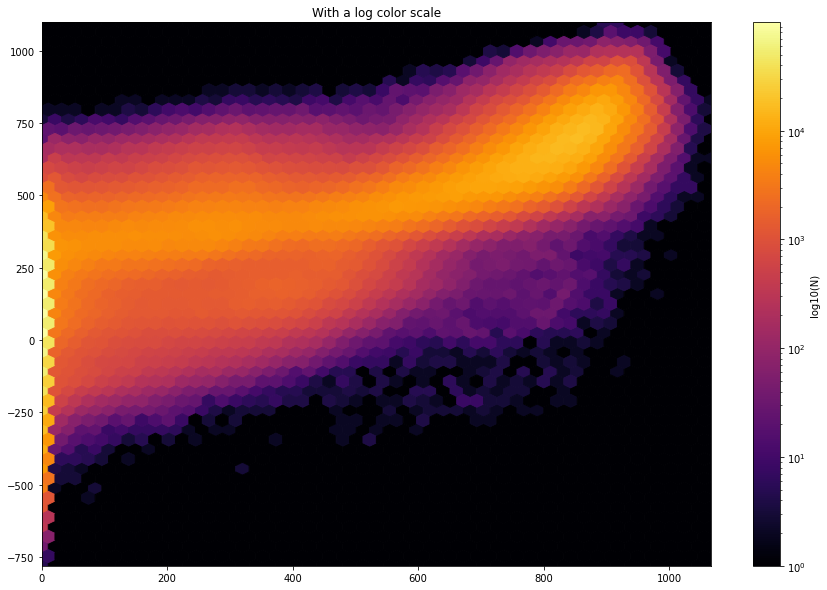

In [ ]:
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(15, 10))


hb = ax.hexbin(df2.DNI,df2.prediction, gridsize=50, bins='log', cmap='inferno')
ax.axis([ ymin, ymax,xmin, xmax])
ax.set_title("With a log color scale")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')

plt.show()

## 3.4 Polynomial regerssion

### Hyperparameter tuning

To search the degree and the best set of feature

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.context import SparkContext
from pyspark.ml.regression import LinearRegression

In [ ]:
# Avoids some problem with the cross validating model

data = data.withColumnRenamed(existing="DNI", new = "label")

In [ ]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=[ 'Month', 'Day', 'Hour', 'Temperature', 'Cloud Type', 'Dew Point',  'Fill Flag', 'Ozone', 'Relative Humidity', 'Solar Zenith Angle', 'Surface Albedo', 'Pressure', 'Precipitable Water', 'Wind Direction', 'Wind Speed', 'lat', 'lon', 'Elevation','region_name'],outputCol="features")
#data_2 = assembler.transform(data)

In [ ]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['Hour','Temperature', 'Cloud Type',  'Fill Flag', 'Relative Humidity', 'Solar Zenith Angle'],outputCol="features")
data_2 = assembler.transform(data)

Generate combination of n features; 4-5 features per iteration is the possible maximum to not crash the regression

In [ ]:
import itertools
feature_comb_ls = list(itertools.combinations(['Temperature', 'Cloud Type',  'Fill Flag', 'Relative Humidity', 'Solar Zenith Angle', 'Hour', 'Dew Point'], 4)) #most significant features; 12hrs to compute

In [ ]:
feature_comb_ls[:2]

[('Month', 'Day', 'Hour', 'Temperature', 'Cloud Type'),
 ('Month', 'Day', 'Hour', 'Temperature', 'Dew Point')]

In [ ]:
len(feature_comb_ls)

5

Polynomial expansion yields better results than individually change the coefficient of each term

In [ ]:
from pyspark.ml.feature import PolynomialExpansion
from pyspark.ml.linalg import Vectors

polyExpansion = PolynomialExpansion(degree=3, inputCol="features", outputCol="polyFeatures") # 
polyDF = polyExpansion.transform(data_2)

In [ ]:
train, test = data.randomSplit([0.7, 0.3])

In [ ]:
train, test = polyDF.randomSplit([0.7, 0.3])

In [ ]:
from pyspark.ml.regression import LinearRegression
rf = LinearRegression(featuresCol="polyFeatures", labelCol="label")

Pipeline: assemble features in one vector, compute the polinomial expansion, then start the regression

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[assembler, polyExpansion, rf])

In [ ]:
import numpy as np
from pyspark.ml.tuning import ParamGridBuilder
paramGrid = ParamGridBuilder()\
.addGrid(assembler.inputCols, [list(x) for x in feature_comb_ls])\
.addGrid(polyExpansion.degree,[int(x) for x in np.linspace(start = 3, stop = 4)] )\
.build()

#
#feature_comb_ls
#.addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 10, num = 8)])\

CrossValidator takes too much time and RAM

In [ ]:
'''from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=2) #3
                        #default RegressionEvaluator metric: RMSE'''

In [ ]:
#cvModel = crossval.fit(train)

In [ ]:
#cvModel.save(path+"polynomial_complete_grid"+filename)

In [ ]:
#bestPipeline = cvModel.bestModel
#bestModel = bestPipeline.stages[2]

In [ ]:
#bestModel.save(path+"best_model_polynimial_grid"+filename)

TrainValidationSplit is more than 3 times faster, at the cost of being less precise

In [ ]:

from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train)

Save values

In [ ]:
model.save(path+"only_model_polynimial_grid"+filename)

In [ ]:
print("saved")

Reload values

In [ ]:
from pyspark.ml.regression import  LinearRegressionModel
model =  LinearRegressionModel.load(path+"6f_3deg_polynimia"+filename) #path+"6f_3deg_polynimia"+filename besst 6 f 3 deg

-------

In [ ]:
df = model.transform(polyDF).select('prediction', 'Month', 'Hour', 'lat', 'lon', 'region_name').toPandas()

In [ ]:
df.to_csv("/content/drive/MyDrive/solar_irr_pred/bestPolymodel_dataset_pred.csv", index=False)

---------

#### Evaluation

In [ ]:
test = test.sample(0.10)

In [ ]:
evaluation_summary = model.evaluate(test)

In [ ]:
evaluation_summary.meanAbsoluteError #85.68571294471246



88.30547422373313

In [ ]:
evaluation_summary.meanSquaredError
#14127.699550582112



14528.91672243508

In [ ]:
evaluation_summary.r2 #0.8787412042889032

0.8787290943809877

In [ ]:
evaluation_summary.rootMeanSquaredError

120.53595613938225

In [ ]:
evaluation_summary.explainedVariance #102391.63041231954

105299.66362573225

In [ ]:
predictions = model.transform(test)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Plotting library
import seaborn as sns   # Plotting library
df = predictions.select("label", "prediction").toPandas()

In [ ]:
#df.to_csv("/content/drive/MyDrive/solar_irr_pred/removed_zenith_pol_expansion_results.csv", index = False)

In [ ]:
print("Intercept: " + str(model.intercept))
print("Coefficient: " + str(model.coefficients))

Intercept: -951.4518862747148
Coefficient: [267.5147311846577,-10.738942630537588,0.018119592521134466,26.283908218387005,-3.624196506159684,0.12273837033871442,-0.06230037187992204,0.008769112085189478,-0.003541149733378326,-627.6248452014007,-10.915694710785038,0.5017826363409253,7.475292752144685,0.0023228097948163277,-0.00258442856697246,89.03818799644144,-0.07173510240113846,-0.6698341188941506,-2.0070519504628845,-211.30116568830988,5.144644329387937,0.18858230104999762,0.26930780495407947,0.008495926718641,0.05412001031210147,2.655049440378531,0.02479861509052358,0.3141334159641169,-1.6299385589809123,38.08468378912965,-0.10633837078629432,-1.5951662455339135,0.3605158953010798,7.747713203118603,21.902027006822806,-1.1033910901207937,0.02482510196830472,-0.5333880339776882,0.004587398756563657,0.005593473264523061,-0.31800711402479215,-0.003402400709350698,0.018333037644771503,-0.16681434367066597,0.9041307666252638,-0.023846449625441964,0.0013318403805727597,0.1053955440043012,

In [ ]:
xmin = min(df.prediction)
xmax = max(df.prediction)
ymin = min(df.label)
ymax = max(df.label)

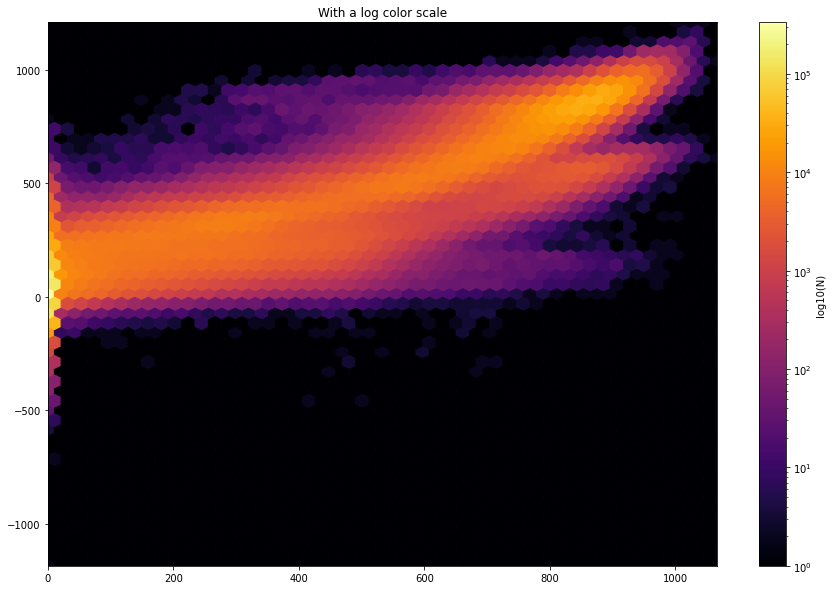

In [ ]:
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(15, 10))


hb = ax.hexbin(df.label,df.prediction, gridsize=50, bins='log', cmap='inferno')
ax.axis([ ymin, ymax,xmin, xmax])
ax.set_title("With a log color scale")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')

plt.show()

# Extras

<h3>Miscellaneous code that was useful </**h3**>

## Create dataframe and prepare it for the heatmap

**<h2> ! This code has been used to create the site that shows predicted DNI on maps </h2>**

First of all, to create a heatmap, one should weight values; i used the median.
Of course, DNI is the one that should be weighted; but it can't just use it as it is, because large part of the dataset has DNI = 0, and the median would be too low. So i took the values only after the sunrise and before the sunset, calculating it using coordinates

### Class that comprehends calculation to estimate sunrise & sunset given lat, lon coordinates

In [ ]:
# save this as Sun.py
#Taken from https://stackoverflow.com/questions/19615350/calculate-sunrise-and-sunset-times-for-a-given-gps-coordinate-within-postgresql
import math
import datetime

class Sun:

    def getSunriseTime( self, coords ):
        return self.calcSunTime( coords, True )

    def getSunsetTime( self, coords ):
        return self.calcSunTime( coords, False )

    def getCurrentUTC( self ):
        now = datetime.datetime.now()
        return [ now.day, now.month, now.year ]

    def calcSunTime( self, coords, isRiseTime, zenith = 90.8 ):

        # isRiseTime == False, returns sunsetTime

        day, month, year = self.getCurrentUTC()

        longitude = coords['longitude']
        latitude = coords['latitude']

        TO_RAD = math.pi/180

        #1. first calculate the day of the year
        N1 = math.floor(275 * month / 9)
        N2 = math.floor((month + 9) / 12)
        N3 = (1 + math.floor((year - 4 * math.floor(year / 4) + 2) / 3))
        N = N1 - (N2 * N3) + day - 30

        #2. convert the longitude to hour value and calculate an approximate time
        lngHour = longitude / 15

        if isRiseTime:
            t = N + ((6 - lngHour) / 24)
        else: #sunset
            t = N + ((18 - lngHour) / 24)

        #3. calculate the Sun's mean anomaly
        M = (0.9856 * t) - 3.289

        #4. calculate the Sun's true longitude
        L = M + (1.916 * math.sin(TO_RAD*M)) + (0.020 * math.sin(TO_RAD * 2 * M)) + 282.634
        L = self.forceRange( L, 360 ) #NOTE: L adjusted into the range [0,360)

        #5a. calculate the Sun's right ascension

        RA = (1/TO_RAD) * math.atan(0.91764 * math.tan(TO_RAD*L))
        RA = self.forceRange( RA, 360 ) #NOTE: RA adjusted into the range [0,360)

        #5b. right ascension value needs to be in the same quadrant as L
        Lquadrant  = (math.floor( L/90)) * 90
        RAquadrant = (math.floor(RA/90)) * 90
        RA = RA + (Lquadrant - RAquadrant)

        #5c. right ascension value needs to be converted into hours
        RA = RA / 15

        #6. calculate the Sun's declination
        sinDec = 0.39782 * math.sin(TO_RAD*L)
        cosDec = math.cos(math.asin(sinDec))

        #7a. calculate the Sun's local hour angle
        cosH = (math.cos(TO_RAD*zenith) - (sinDec * math.sin(TO_RAD*latitude))) / (cosDec * math.cos(TO_RAD*latitude))

        if cosH > 1:
            return {'status': False, 'msg': 'the sun never rises on this location (on the specified date)'}

        if cosH < -1:
            return {'status': False, 'msg': 'the sun never sets on this location (on the specified date)'}

        #7b. finish calculating H and convert into hours

        if isRiseTime:
            H = 360 - (1/TO_RAD) * math.acos(cosH)
        else: #setting
            H = (1/TO_RAD) * math.acos(cosH)

        H = H / 15

        #8. calculate local mean time of rising/setting
        T = H + RA - (0.06571 * t) - 6.622

        #9. adjust back to UTC
        UT = T - lngHour
        UT = self.forceRange( UT, 24) # UTC time in decimal format (e.g. 23.23)

        #10. Return
        hr = self.forceRange(int(UT), 24)
        min = round((UT - int(UT))*60,0)

        return {
            'status': True,
            'decimal': UT,
            'hr': hr,
            'min': min 
        }

    def forceRange( self, v, max ):
        # force v to be >= 0 and < max
        if v < 0:
            return v + max
        elif v >= max:
            return v - max

        return v

### Calculate median for each coordinate

In [ ]:
def median_coordinates(path):
    #The code to calculate sunrise and sunset easily was taken from https://stackoverflow.com/questions/19615350/calculate-sunrise-and-sunset-times-for-a-given-gps-coordinate-within-postgresql
    import numpy as np
    from Sun import Sun
    df = pd.read_csv(path, usecols=['lat', 'lon', 'DNI', 'Hour','Day', 'Month'])  # or prediction, depending on the heatmap

    ls =  df[['lat','lon']].drop_duplicates().values.tolist()
    d = {"lat,lon": [], "median_DNI": []}
    for x in ls:

        coords = {'longitude':x[0], 'latitude': x[1]}

        sun = Sun()


        actual_sunrise = int(round(sun.getSunriseTime(coords)['decimal'] + 5))

        actual_sunset = int(round(sun.getSunsetTime(coords)['decimal'] + 5))


        d["lat,lon"].append([x[0],x[1]])
        d["median_DNI"].append(df[np.isclose(df["lat"], x[0]) & np.isclose(df["lon"], x[1]) & (df['Hour'] < actual_sunset ) & (df['Hour'] > actual_sunrise) ].median()['DNI'])
    df1 = pd.DataFrame(d)
    print(df1.head())
    df1.to_csv(path+"/median_coordinate.csv", index=False)

### Weight coordinates

In [ ]:
def weight_coordinates_smart(path): #Give the path to median_coordinate.csv
    #{location: new google.maps.LatLng(41.9028 , 12.4964), weight: 1000},

    df = pd.read_csv(path)  # or prediction

    #Normalize values
    df['median_DNI'] = (df['median_DNI'] - df['median_DNI'].min()) / (df['median_DNI'].max() - df['median_DNI'].min())
    #List the coordinates
    ls = df[['lat,lon']].drop_duplicates().values.tolist()
    with open(path+"/weighted_smart_coordinates.txt", 'w') as f:
        for x in ls:
            f.write("{location: new google.maps.LatLng"+x[0].replace('[', '(').replace(']',')')+','+" weight: "+str(df[df['lat,lon'] == x[0]]['median_DNI'].values[0])+'},'+'\n')
            #create the following string: {location: new google.maps.LatLng(41.9028 , 12.4964), weight: 1000},

As stated in the [Google heatmap API documentation](https://developers.google.com/maps/documentation/javascript/heatmaplayer), each point must be weighted, thus i normalized values of DNI

## Shuffle and save with pandas


<h4> Shuffling the dataset yielded slightly better results </h4>

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/solar_irr_pred/final.csv")
df = df.sample(frac=1, random_state=0)
df.to_csv("/content/drive/MyDrive/solar_irr_pred/shuffled.csv", index = False)

In [ ]:
print("24.598.080")
#number of rows

## Convert solar zenith in multilpes of 5

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/solar_irr_pred/shuffled.csv")
df['Solar Zenith Angle']=df['Solar Zenith Angle'].apply(lambda x: 5*(x//5) if x > 1 else 0)
df.to_csv("/content/drive/MyDrive/solar_irr_pred/shuffled.csv", index = False)

In [ ]:
df.to_csv("/content/drive/MyDrive/solar_irr_pred/shuffled.csv", index = False)

## Support csv

Substitute value in a column with 0, 1 when a condition is met

In [ ]:
import numpy as np
df['bigger_90'] = np.where(df['Solar Zenith Angle']>= 90, 1, 0)

In [ ]:
df.to_csv("/content/drive/MyDrive/solar_irr_pred/bigger90_shuffled.csv", index = False)

## Stratified sample

Keep only 10% of values that have a Solar Zenith >= 90°

In [ ]:
data = spark.read.load("/content/drive/MyDrive/solar_irr_pred/shuffled.csv", format="csv", header=True)

In [ ]:
from pyspark.sql import functions as f

In [ ]:
#https://stackoverflow.com/questions/51565395/pyspark-create-new-column-and-fill-in-based-on-conditions-of-two-other-columns <---- Life saver
data = data.withColumn(
    "bigger_90", 
    f.when(data["Solar Zenith Angle"]>= 90, 1)\
    .when(data["Solar Zenith Angle"] < 90, 0)
    )

In [ ]:
data = data.sampleBy("bigger_90", fractions={0: 0.9, 1: 0.1}, seed=0)